In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import arkane
import os
from rmgpy.molecule import Molecule as RMGMolecule
from autotst.calculators.gaussian import Gaussian as AutoTST_Gaussian

import matplotlib.pyplot as plt
%matplotlib inline


Using Theano backend.


In [2]:
SMILES_list = [
    'OOCC(C)O[O]'
    'CCCCO',
    'CCCC[O]',
    'CCC[CH]O',
    'CC[CH]CO',
    'C[CH]CCO',
    '[CH2]CCCO',
    'CCOC',
    'C[CH]OC',
    'CCO[CH2]',
    '[CH2]COC',
    'COC(C)C',
    'CO[C](C)C',
    '[CH2]OC(C)C',
    '[CH2]C(C)OC',
    'CCC(=O)OC',
    'C[CH]C(=O)OC',
    '[CH2]CC(=O)OC',
    '[CH2]OC(=O)CC',
    'ONCC(=O)O'
]

In [3]:
def get_atoms(conf):
    """
    A method to create an atom dictionary for an rmg molecule
    """
    atom_dict = {}

    #conf = Conformer(species.smiles[0])

    rmg_mol = conf.rmg_molecule

    for atom in rmg_mol.atoms:
        if atom.isCarbon():
            atom_type = "C"
        elif atom.isHydrogen():
            atom_type = "H"
        elif atom.isOxygen():
            atom_type = "O"
        elif atom.symbol == 'N':
            atom_type = atom.symbol
        else:
            atom_type = atom.symbol
            
        try:
            atom_dict[atom_type] += 1
        except KeyError:
            atom_dict[atom_type] = 1

    return atom_dict

def get_bonds(conf):


    #conf = Conformer(species.smiles[0])

    rmg_mol = conf.rmg_molecule

    bondList = []
    for atom in rmg_mol.atoms:
        for bond in atom.bonds.values():
            bondList.append(bond)
    bonds = list(set(bondList))
    bondDict = {}
    for bond in bonds:
        if bond.isSingle():
            if bond.atom1.symbol == 'C' and bond.atom2.symbol == 'C':
                bondType = 'C-C'
            elif (bond.atom1.symbol == 'H' and bond.atom2.symbol == 'H'):
                bondType = 'H-H'
            elif (bond.atom1.symbol == 'C' and bond.atom2.symbol == 'H') or (bond.atom1.symbol == 'H' and bond.atom2.symbol == 'C'):
                bondType = 'C-H'
            elif (bond.atom1.symbol == 'O' and bond.atom2.symbol == 'O'):
                bondType = 'O-O'
            elif (bond.atom1.symbol == 'C' and bond.atom2.symbol == 'O') or (bond.atom1.symbol == 'O' and bond.atom2.symbol == 'C'):
                bondType = 'C-O'
            elif (bond.atom1.symbol == 'H' and bond.atom2.symbol == 'O') or (bond.atom1.symbol == 'O' and bond.atom2.symbol == 'H'):
                bondType = 'O-H'
            elif bond.atom1.symbol == 'N' and bond.atom2.symbol == 'N':
                bondType = 'N-N'
            elif (bond.atom1.symbol == 'C' and bond.atom2.symbol == 'N') or (bond.atom1.symbol == 'N' and bond.atom2.symbol == 'C'):
                bondType = 'N-C'
            elif (bond.atom1.symbol == 'O' and bond.atom2.symbol == 'N') or (bond.atom1.symbol == 'N' and bond.atom2.symbol == 'O'):
                bondType = 'N-O'
            elif (bond.atom1.symbol == 'H' and bond.atom2.symbol == 'N') or (bond.atom1.symbol == 'N' and bond.atom2.symbol == 'H'):
                bondType = 'N-H'
            elif bond.atom1.symbol == 'S' and bond.atom2.symbol == 'S':
                bondType = 'S-S'
            elif (bond.atom1.symbol == 'H' and bond.atom2.symbol == 'S') or (bond.atom1.symbol == 'S' and bond.atom2.symbol == 'H'):
                bondType = 'S-H'
        elif bond.isDouble:
            if bond.atom1.symbol == 'C' and bond.atom2.symbol == 'C':
                bondType = 'C=C'
            elif (bond.atom1.symbol == 'O' and bond.atom2.symbol == 'O'):
                bondType = 'O=O'
            elif (bond.atom1.symbol == 'C' and bond.atom2.symbol == 'O') or (bond.atom1.symbol == 'O' and bond.atom2.symbol == 'C'):
                bondType = 'C=O'
            elif bond.atom1.symbol == 'N' and bond.atom2.symbol == 'N':
                bondType = 'N=N'
            elif (bond.atom1.symbol == 'C' and bond.atom2.symbol == 'N') or (bond.atom1.symbol == 'N' and bond.atom2.symbol == 'C'):
                bondType = 'N=C'
            elif (bond.atom1.symbol == 'O' and bond.atom2.symbol == 'N') or (bond.atom1.symbol == 'N' and bond.atom2.symbol == 'O'):
                bondType = 'N=O'
            elif (bond.atom1.symbol == 'O' and bond.atom2.symbol == 'S') or (bond.atom1.symbol == 'S' and bond.atom2.symbol == 'O'):
                bondType = 'S=O'
        elif bond.isTriple:
            if bond.atom1.symbol == 'C' and bond.atom2.symbol == 'C':
                bondType = 'C#C'
            elif bond.atom1.symbol == 'N' and bond.atom2.symbol == 'N':
                bondType = 'N#N'
            elif (bond.atom1.symbol == 'C' and bond.atom2.symbol == 'N') or (bond.atom1.symbol == 'N' and bond.atom2.symbol == 'C'):
                bondType = 'N#C'
        try:
            bondDict[bondType] += 1
        except KeyError:
            bondDict[bondType] = 1

    return bondDict

def exists_and_complete(path):
    exists_and_complete = False
    auto_g = AutoTST_Gaussian()
    
    if os.path.isfile(path):
        if False not in auto_g.verify_output_file(path):
            exists_and_complete = True
    
    return exists_and_complete


def write_ArkaneThermoInput(filename, modelChemistry, spec_name, spec_file, path=None, use_hindered = True):
    """
    Writes thermo input file for Arkane
    
    filename :: name of file that will be written to
    modelChemistry :: ModelChemistry used when finding opt geometry and frequencies
    spec_name :: label for species
    spec_file :: name of species file (needs to be in the same directory)
    """
    
    
    output = ['#!/usr/bin/env python',
              '# -*- coding: utf-8 -*-',
              '',
              'modelChemistry = "{0}"'.format(modelChemistry),
              'useHinderedRotors = {0}'.format(use_hindered),
              'useBondCorrections = True',
              '',
              "species('{0}', '{1}')\n\nstatmech('{0}')".format(spec_name, spec_file),
              "thermo('{0}', '{1}')".format(spec_name, 'NASA')]

    output = '\n'.join(output)

    if path is None:
        path = os.getcwd()
    
    with open(os.path.join(path,filename), 'w') as f:
        f.write(output)
    
    return

def write_arkane_species(conformer, filename, modelChemistry, freq_log, path, rotor_info=None):
    """
    a method to write species to an arkane input file. Mol is an RMGMolecule
    """
    
    conf = conformer

    mol = conf.rmg_molecule

    output = ['#!/usr/bin/env python',
              '# -*- coding: utf-8 -*-', '', 'atoms = {']

    atom_dict = get_atoms(conf)

    for atom, count in atom_dict.iteritems():
        output.append("    '{0}': {1},".format(atom, count))
    output = output + ['}', '']

    bond_dict = get_bonds(conf)
    if bond_dict != {}:
        output.append('bonds = {')
        for bond_type, num in bond_dict.iteritems():
            output.append("    '{0}': {1},".format(bond_type, num))
        output.append("}")
    else:
        output.append('bonds = {}')

    external_symmetry = mol.getSymmetryNumber()

    output += ["",
               "linear = False",
               "",
               "externalSymmetry = {}".format(external_symmetry),
               "",
               "spinMultiplicity = {}".format(mol.multiplicity),
               "",
               "opticalIsomers = 1",
               ""]

    output += ["energy = {", "    '{0}': Log('{1}'),".format(
        modelChemistry, freq_log), "}", ""]

    output += ["geometry = Log('{0}')".format(freq_log), ""]

    output += [
        "frequencies = Log('{0}')".format(freq_log), ""]
    
    if rotor_info is not None:
        output += [rotor_info]

    input_string = '\n'.join(output)
    input_string += '\n'
    #print input_string

    

    with open(os.path.join(path, filename), "w") as f:
        f.write(input_string)
        

def get_rotor_line(conformer, torsion, scan_log):
    """
    Formats and returns info about torsion as it should appear in an Arkane species.py
    conformer :: autotst conformer object
    torsion   :: autotst torsion object 
    Needed for Arkane species file:
    scanLog :: Gaussian output log of freq calculation on optimized geometry
    pivots  :: torsion center: j,k of i,j,k,l (Note Arkane begins indexing with 1)
    top     :: ID of all atoms in one top (Note Arkane begins indexing with 1)
    """
    i,j,k,l = torsion.atom_indices

    tor_center = [j,k]
    tor_center_adj = [j+1, k+1] # Adjusted since mol's IDs start from 0 while Arkane's start from 1

    top_IDs = []
    for num, tf in enumerate(torsion.mask):
        if tf: top_IDs.append(num)

    top_IDs_adj = [ID+1 for ID in top_IDs] # Adjusted to start from 1 instead of 0

    info = "     HinderedRotor(scanLog=Log('{0}'), pivots={1}, top={2}, fit='fourier'),".format(scan_log, tor_center_adj, top_IDs_adj)

    return info

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/CCCCO/From_Workflow
Arkane execution initiated at Wed Apr 24 12:34:15 2019

################################################################
#                                                              #
# Automated Reaction Kinetics and Network Exploration (Arkane) #
#                                                              #
#   Version: 2.3.0                                             #
#   Authors: RMG Developers (rmg_dev@mit.edu)                  #
#   P.I.s:   William H. Green (whgreen@mit.edu)                #
#            Richard H. West (r.west@neu.edu)                  #
#   Website: http://reactionmechanismgenerator.github.io/      #
#                                                              #
################################################################

Loading species LRHPLDYG_for...
Assigned a frequency scale factor of 0.955 for model chemistry M06-2X/cc-pVTZ


Loading statistical mechanics parameters fo

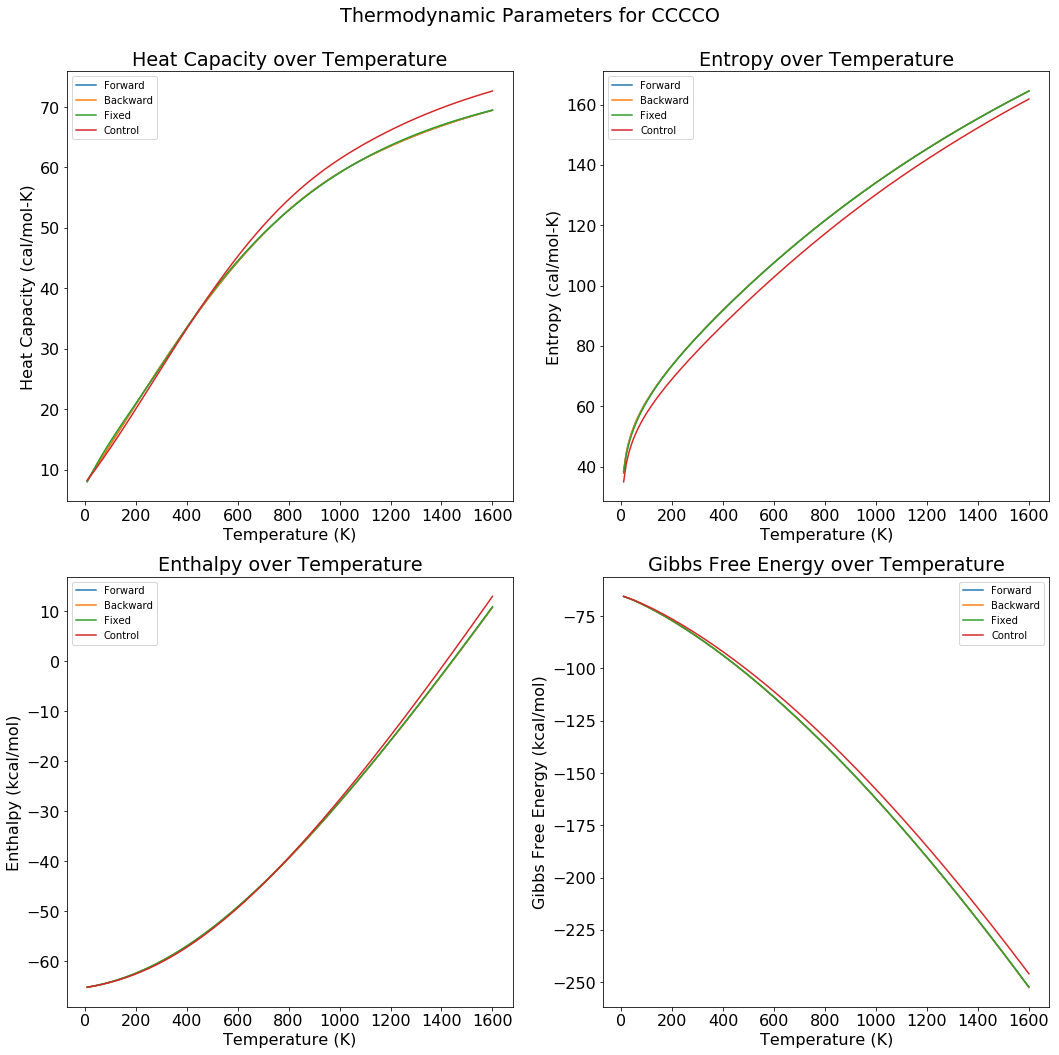

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/CCCC[O]/From_Workflow
Arkane execution initiated at Wed Apr 24 12:34:22 2019

################################################################
#                                                              #
# Automated Reaction Kinetics and Network Exploration (Arkane) #
#                                                              #
#   Version: 2.3.0                                             #
#   Authors: RMG Developers (rmg_dev@mit.edu)                  #
#   P.I.s:   William H. Green (whgreen@mit.edu)                #
#            Richard H. West (r.west@neu.edu)                  #
#   Website: http://reactionmechanismgenerator.github.io/      #
#                                                              #
################################################################

Loading species QOOQLKSE_for...
Assigned a frequency scale factor of 0.955 for model chemistry M06-2X/cc-pVTZ


Loading statistical mechanics parameters 

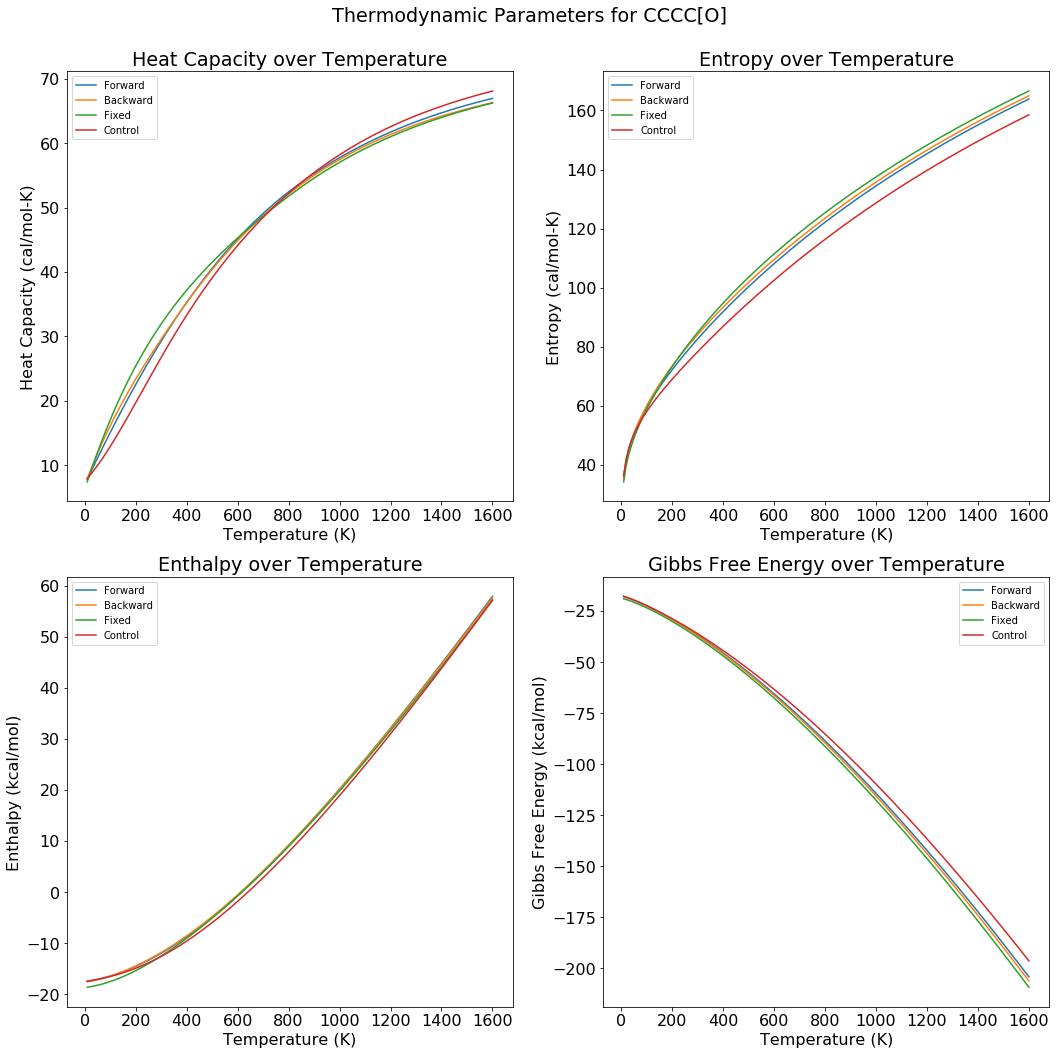

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/CCC[CH]O/From_Workflow
Arkane execution initiated at Wed Apr 24 12:34:29 2019

################################################################
#                                                              #
# Automated Reaction Kinetics and Network Exploration (Arkane) #
#                                                              #
#   Version: 2.3.0                                             #
#   Authors: RMG Developers (rmg_dev@mit.edu)                  #
#   P.I.s:   William H. Green (whgreen@mit.edu)                #
#            Richard H. West (r.west@neu.edu)                  #
#   Website: http://reactionmechanismgenerator.github.io/      #
#                                                              #
################################################################

Loading species DHVSQGCG_for...
Assigned a frequency scale factor of 0.955 for model chemistry M06-2X/cc-pVTZ


Loading statistical mechanics parameters

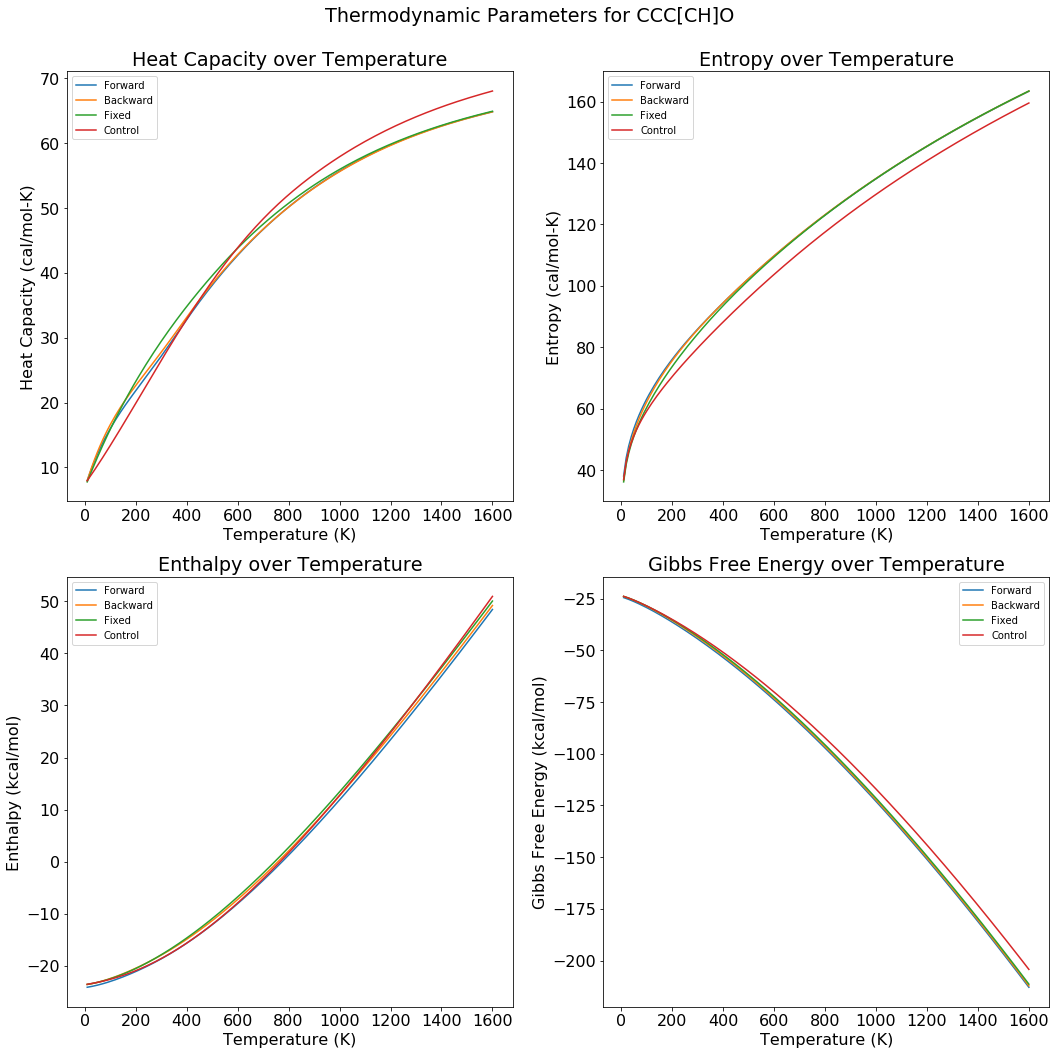

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/CC[CH]CO/From_Workflow
Arkane execution initiated at Wed Apr 24 12:34:37 2019

################################################################
#                                                              #
# Automated Reaction Kinetics and Network Exploration (Arkane) #
#                                                              #
#   Version: 2.3.0                                             #
#   Authors: RMG Developers (rmg_dev@mit.edu)                  #
#   P.I.s:   William H. Green (whgreen@mit.edu)                #
#            Richard H. West (r.west@neu.edu)                  #
#   Website: http://reactionmechanismgenerator.github.io/      #
#                                                              #
################################################################

Loading species GIXGVIVA_for...
Assigned a frequency scale factor of 0.955 for model chemistry M06-2X/cc-pVTZ


Loading statistical mechanics parameters

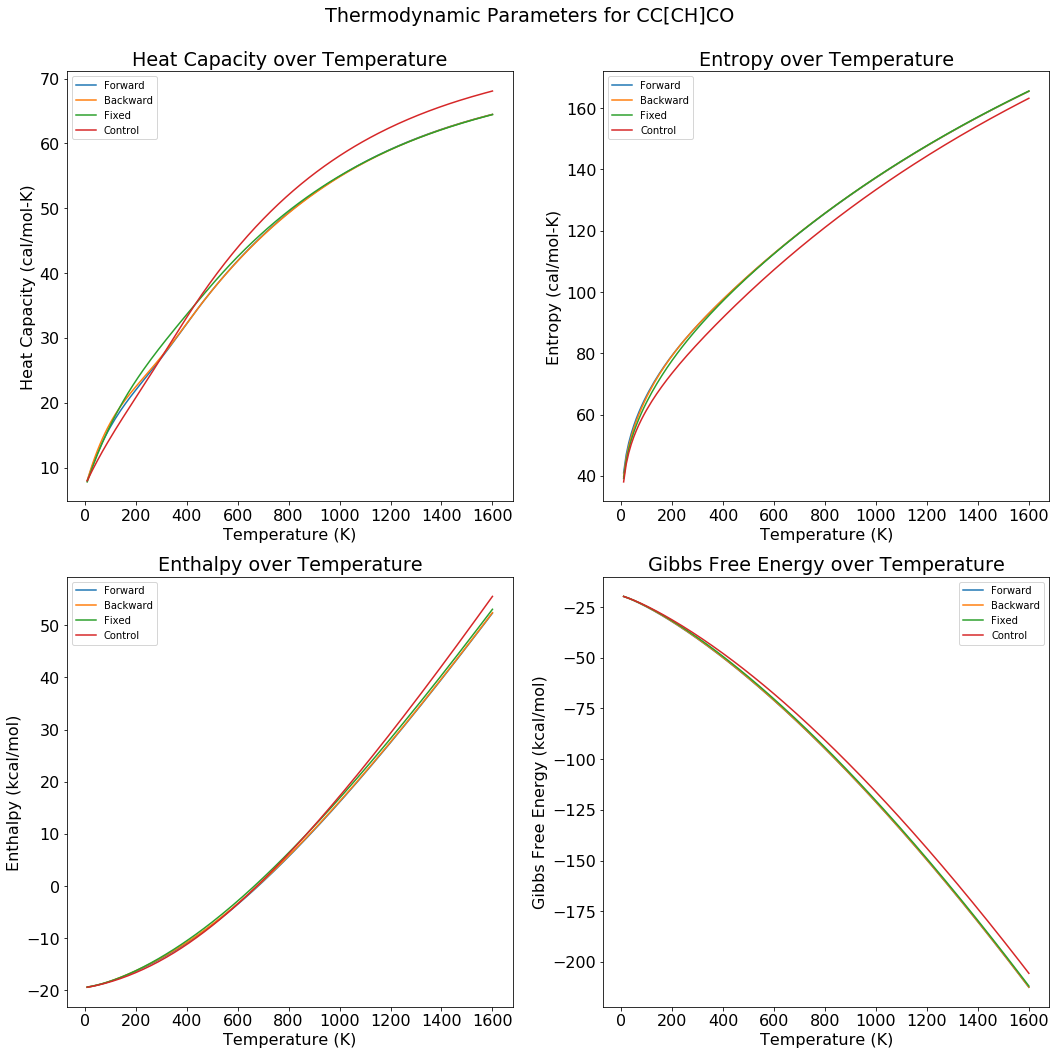

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/C[CH]CCO/From_Workflow
Arkane execution initiated at Wed Apr 24 12:34:44 2019

################################################################
#                                                              #
# Automated Reaction Kinetics and Network Exploration (Arkane) #
#                                                              #
#   Version: 2.3.0                                             #
#   Authors: RMG Developers (rmg_dev@mit.edu)                  #
#   P.I.s:   William H. Green (whgreen@mit.edu)                #
#            Richard H. West (r.west@neu.edu)                  #
#   Website: http://reactionmechanismgenerator.github.io/      #
#                                                              #
################################################################

Loading species DBQZVPSK_for...
Assigned a frequency scale factor of 0.955 for model chemistry M06-2X/cc-pVTZ


Loading statistical mechanics parameters

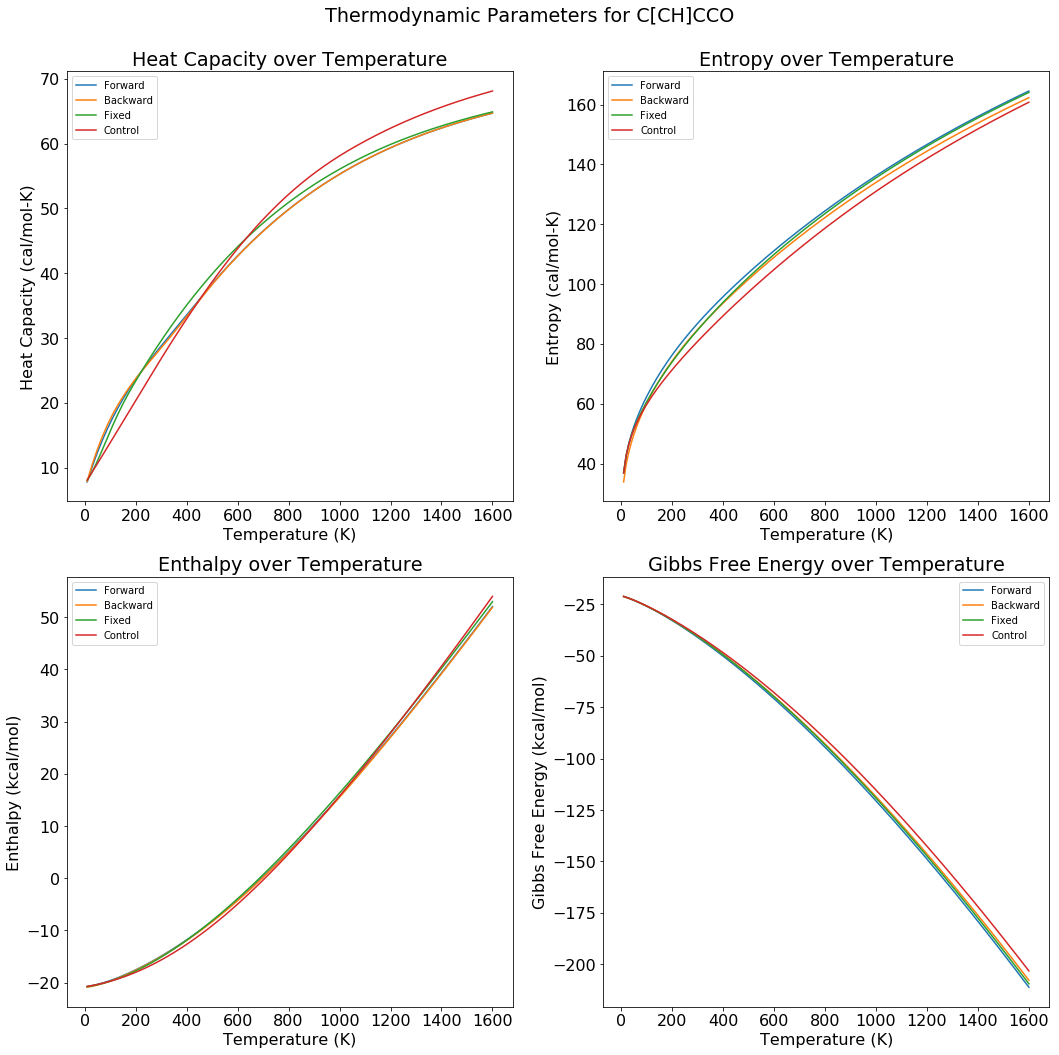

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/[CH2]CCCO/From_Workflow
Arkane execution initiated at Wed Apr 24 12:34:52 2019

################################################################
#                                                              #
# Automated Reaction Kinetics and Network Exploration (Arkane) #
#                                                              #
#   Version: 2.3.0                                             #
#   Authors: RMG Developers (rmg_dev@mit.edu)                  #
#   P.I.s:   William H. Green (whgreen@mit.edu)                #
#            Richard H. West (r.west@neu.edu)                  #
#   Website: http://reactionmechanismgenerator.github.io/      #
#                                                              #
################################################################

Loading species SXIFAEWF_for...
Assigned a frequency scale factor of 0.955 for model chemistry M06-2X/cc-pVTZ


Loading statistical mechanics parameter

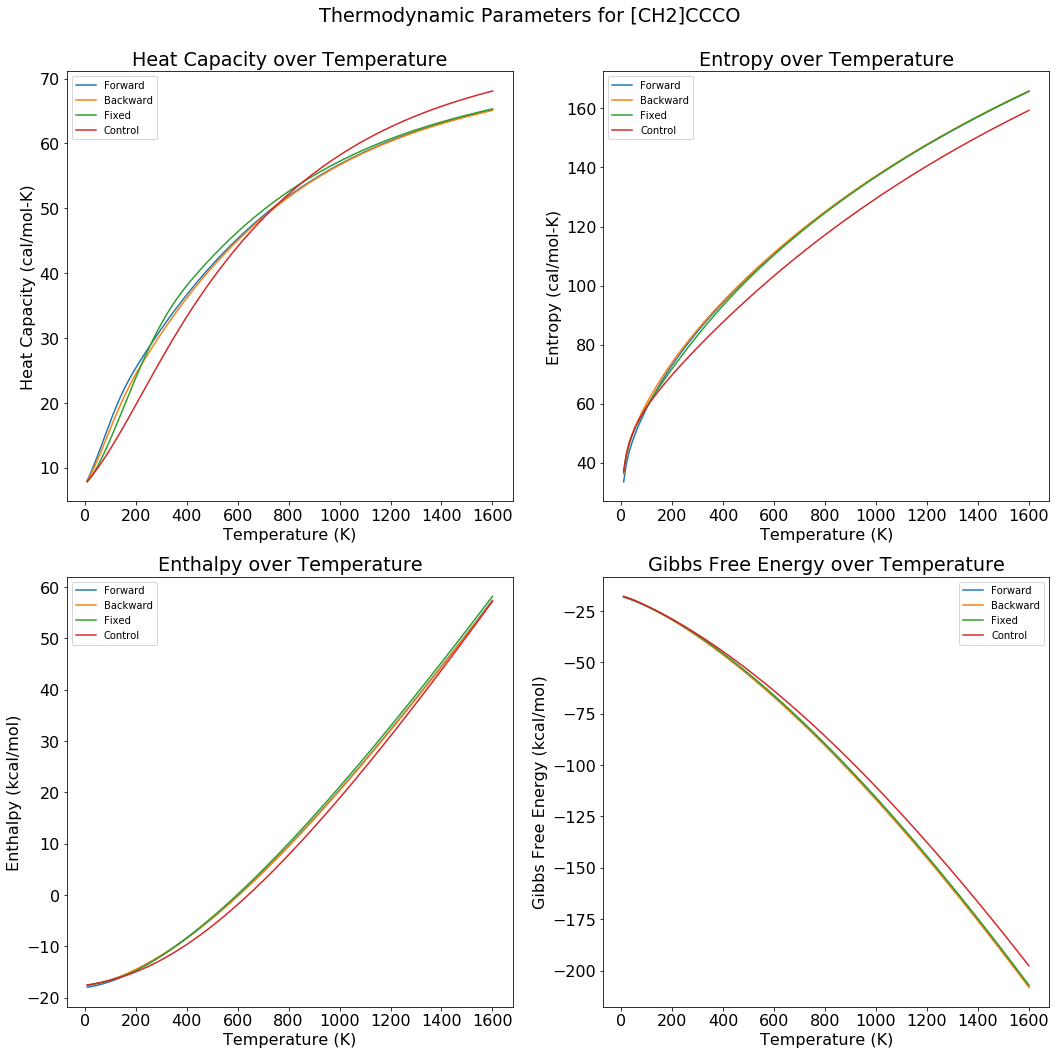

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/CCOC/From_Workflow
Arkane execution initiated at Wed Apr 24 12:35:00 2019

################################################################
#                                                              #
# Automated Reaction Kinetics and Network Exploration (Arkane) #
#                                                              #
#   Version: 2.3.0                                             #
#   Authors: RMG Developers (rmg_dev@mit.edu)                  #
#   P.I.s:   William H. Green (whgreen@mit.edu)                #
#            Richard H. West (r.west@neu.edu)                  #
#   Website: http://reactionmechanismgenerator.github.io/      #
#                                                              #
################################################################

Loading species XOBKSJJD_for...
Assigned a frequency scale factor of 0.955 for model chemistry M06-2X/cc-pVTZ


Loading statistical mechanics parameters for

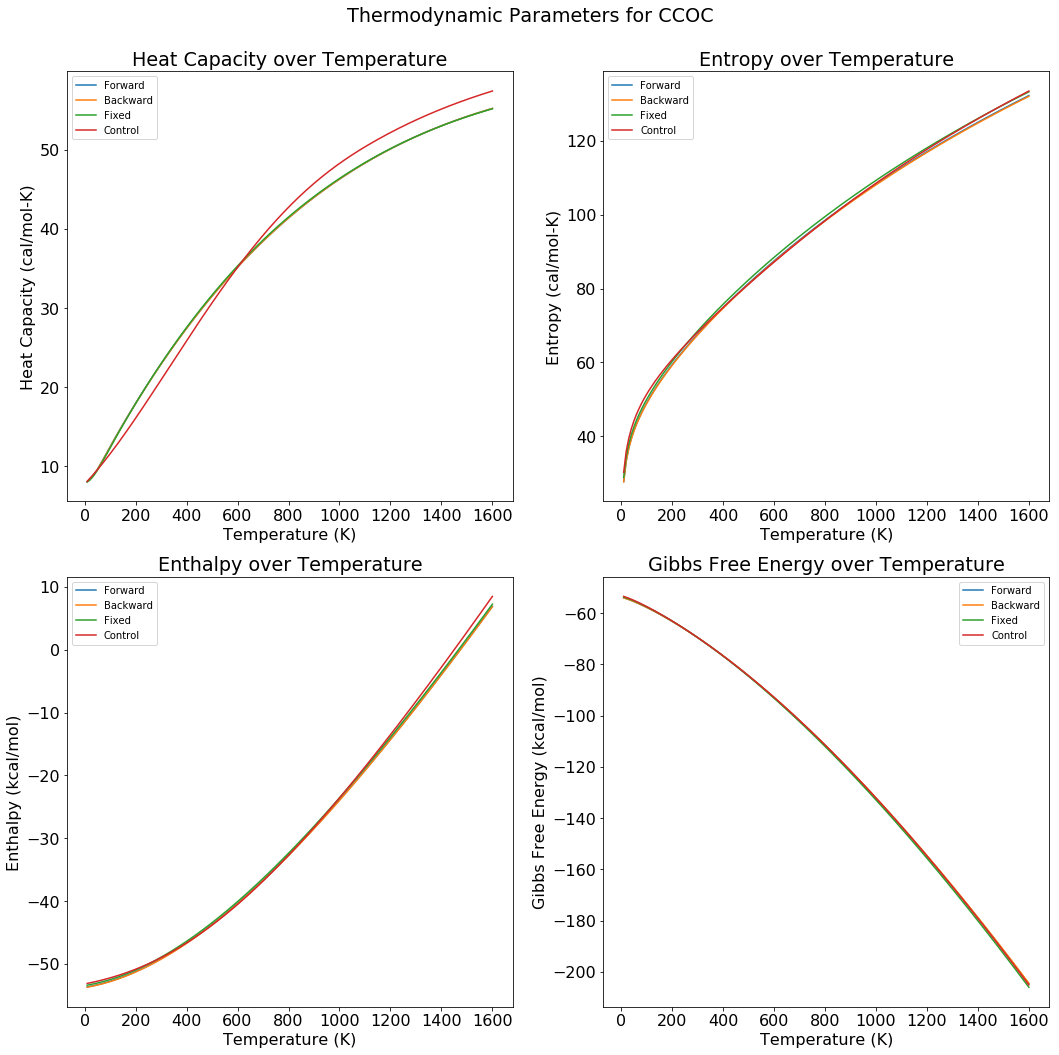

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/C[CH]OC/From_Workflow
Arkane execution initiated at Wed Apr 24 12:35:06 2019

################################################################
#                                                              #
# Automated Reaction Kinetics and Network Exploration (Arkane) #
#                                                              #
#   Version: 2.3.0                                             #
#   Authors: RMG Developers (rmg_dev@mit.edu)                  #
#   P.I.s:   William H. Green (whgreen@mit.edu)                #
#            Richard H. West (r.west@neu.edu)                  #
#   Website: http://reactionmechanismgenerator.github.io/      #
#                                                              #
################################################################

Loading species JQCSUVJD_for...
Assigned a frequency scale factor of 0.955 for model chemistry M06-2X/cc-pVTZ


Loading statistical mechanics parameters 

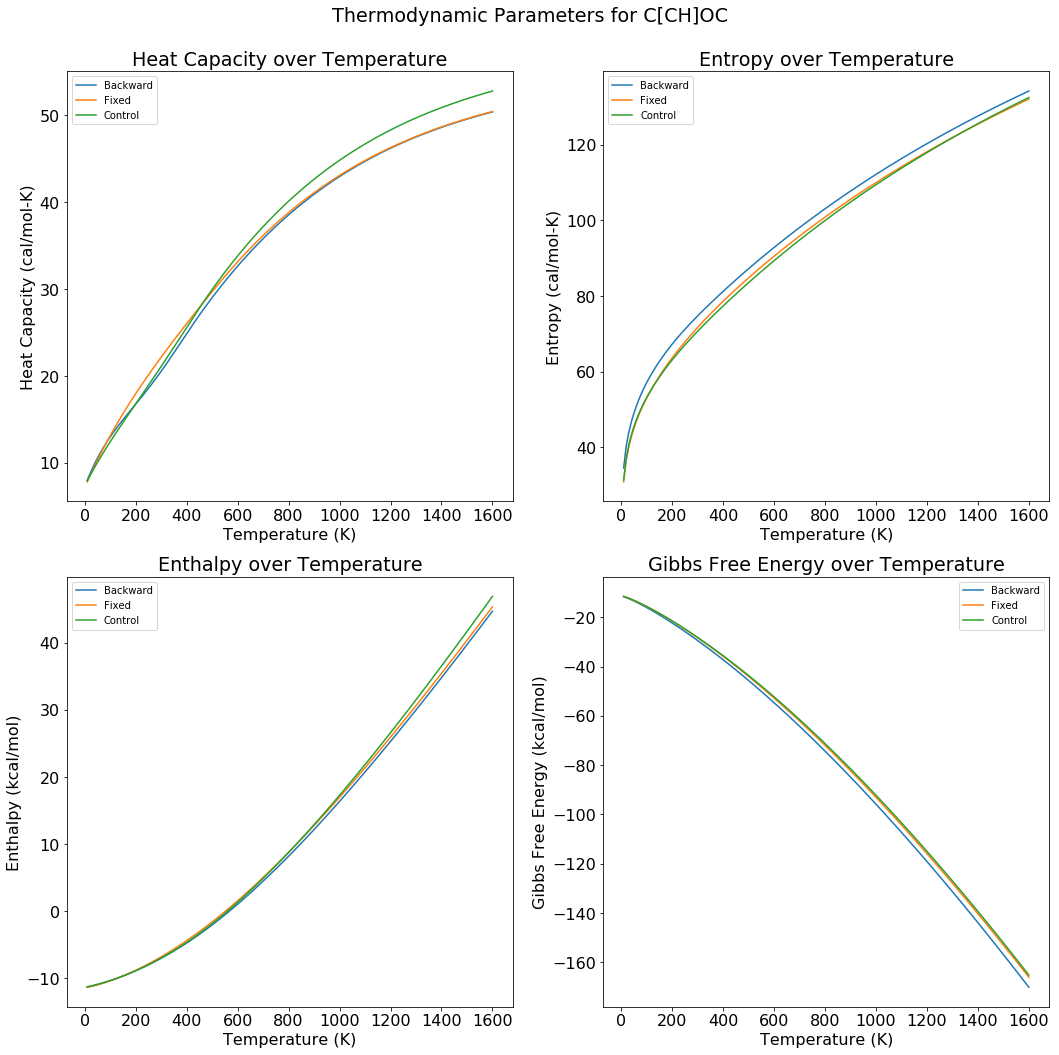

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/CCO[CH2]/From_Workflow
Arkane execution initiated at Wed Apr 24 12:35:12 2019

################################################################
#                                                              #
# Automated Reaction Kinetics and Network Exploration (Arkane) #
#                                                              #
#   Version: 2.3.0                                             #
#   Authors: RMG Developers (rmg_dev@mit.edu)                  #
#   P.I.s:   William H. Green (whgreen@mit.edu)                #
#            Richard H. West (r.west@neu.edu)                  #
#   Website: http://reactionmechanismgenerator.github.io/      #
#                                                              #
################################################################

Loading species TVFRQKHU_for...
Assigned a frequency scale factor of 0.955 for model chemistry M06-2X/cc-pVTZ


Loading statistical mechanics parameters

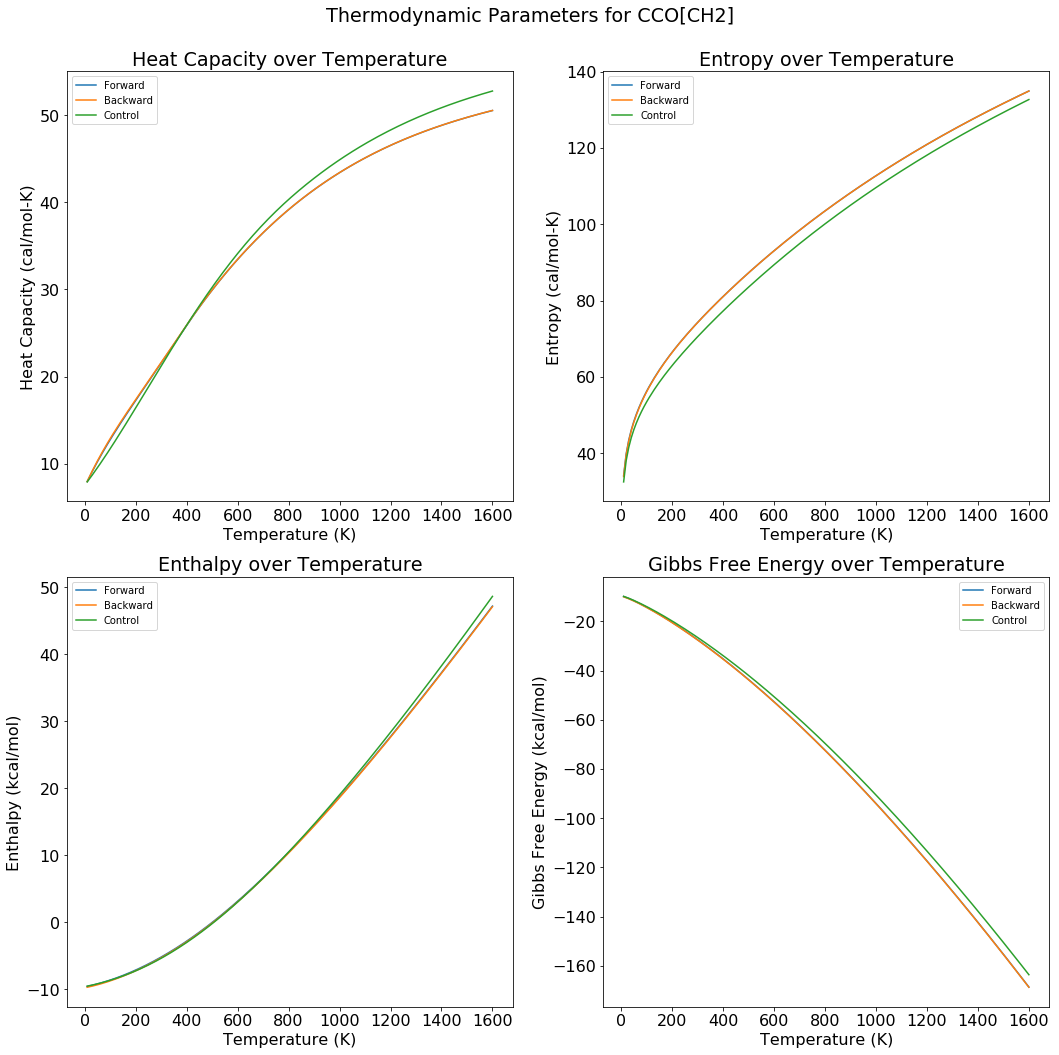

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/[CH2]COC/From_Workflow
Arkane execution initiated at Wed Apr 24 12:35:18 2019

################################################################
#                                                              #
# Automated Reaction Kinetics and Network Exploration (Arkane) #
#                                                              #
#   Version: 2.3.0                                             #
#   Authors: RMG Developers (rmg_dev@mit.edu)                  #
#   P.I.s:   William H. Green (whgreen@mit.edu)                #
#            Richard H. West (r.west@neu.edu)                  #
#   Website: http://reactionmechanismgenerator.github.io/      #
#                                                              #
################################################################

Loading species ZMAYDFGN_for...
Assigned a frequency scale factor of 0.955 for model chemistry M06-2X/cc-pVTZ


Loading statistical mechanics parameters

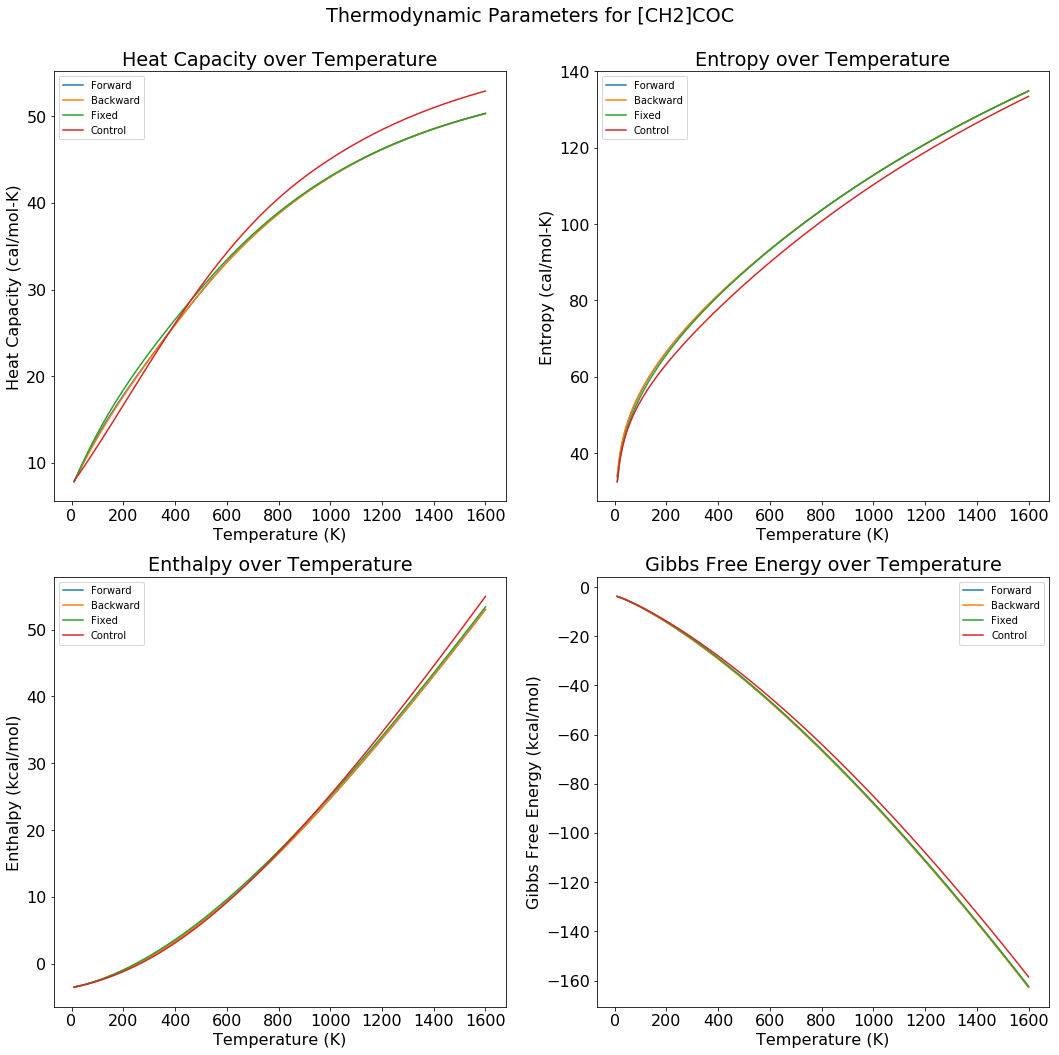

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/COC(C)C/From_Workflow
Arkane execution initiated at Wed Apr 24 12:35:24 2019

################################################################
#                                                              #
# Automated Reaction Kinetics and Network Exploration (Arkane) #
#                                                              #
#   Version: 2.3.0                                             #
#   Authors: RMG Developers (rmg_dev@mit.edu)                  #
#   P.I.s:   William H. Green (whgreen@mit.edu)                #
#            Richard H. West (r.west@neu.edu)                  #
#   Website: http://reactionmechanismgenerator.github.io/      #
#                                                              #
################################################################

Loading species RMGHERXM_for...
Assigned a frequency scale factor of 0.955 for model chemistry M06-2X/cc-pVTZ


Loading statistical mechanics parameters 

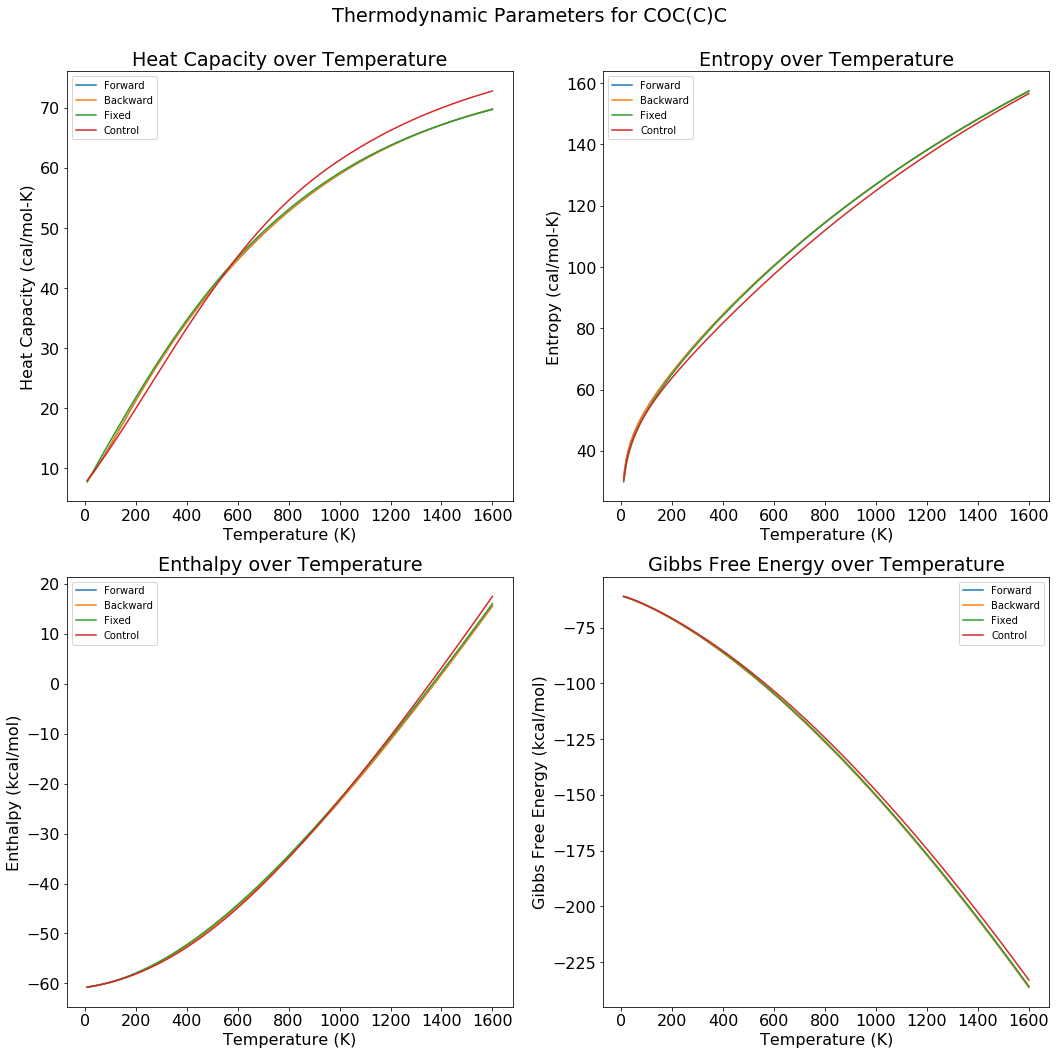

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/CO[C](C)C/From_Workflow
Arkane execution initiated at Wed Apr 24 12:35:32 2019

################################################################
#                                                              #
# Automated Reaction Kinetics and Network Exploration (Arkane) #
#                                                              #
#   Version: 2.3.0                                             #
#   Authors: RMG Developers (rmg_dev@mit.edu)                  #
#   P.I.s:   William H. Green (whgreen@mit.edu)                #
#            Richard H. West (r.west@neu.edu)                  #
#   Website: http://reactionmechanismgenerator.github.io/      #
#                                                              #
################################################################

Loading species VSQGJBCH_for...
Assigned a frequency scale factor of 0.955 for model chemistry M06-2X/cc-pVTZ


Loading statistical mechanics parameter

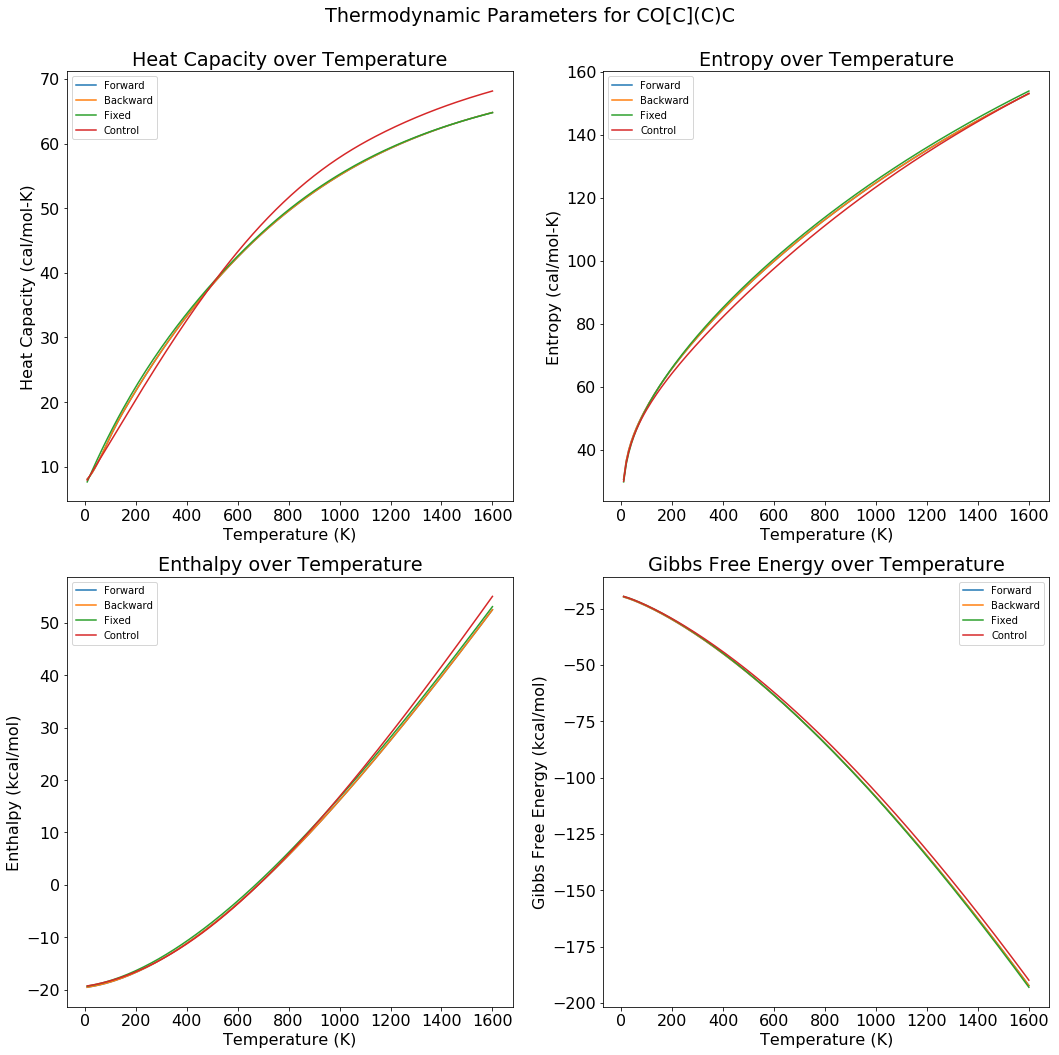

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/[CH2]OC(C)C/From_Workflow
Arkane execution initiated at Wed Apr 24 12:35:40 2019

################################################################
#                                                              #
# Automated Reaction Kinetics and Network Exploration (Arkane) #
#                                                              #
#   Version: 2.3.0                                             #
#   Authors: RMG Developers (rmg_dev@mit.edu)                  #
#   P.I.s:   William H. Green (whgreen@mit.edu)                #
#            Richard H. West (r.west@neu.edu)                  #
#   Website: http://reactionmechanismgenerator.github.io/      #
#                                                              #
################################################################

Loading species BWWHSGPV_for...
Assigned a frequency scale factor of 0.955 for model chemistry M06-2X/cc-pVTZ


Loading statistical mechanics paramet

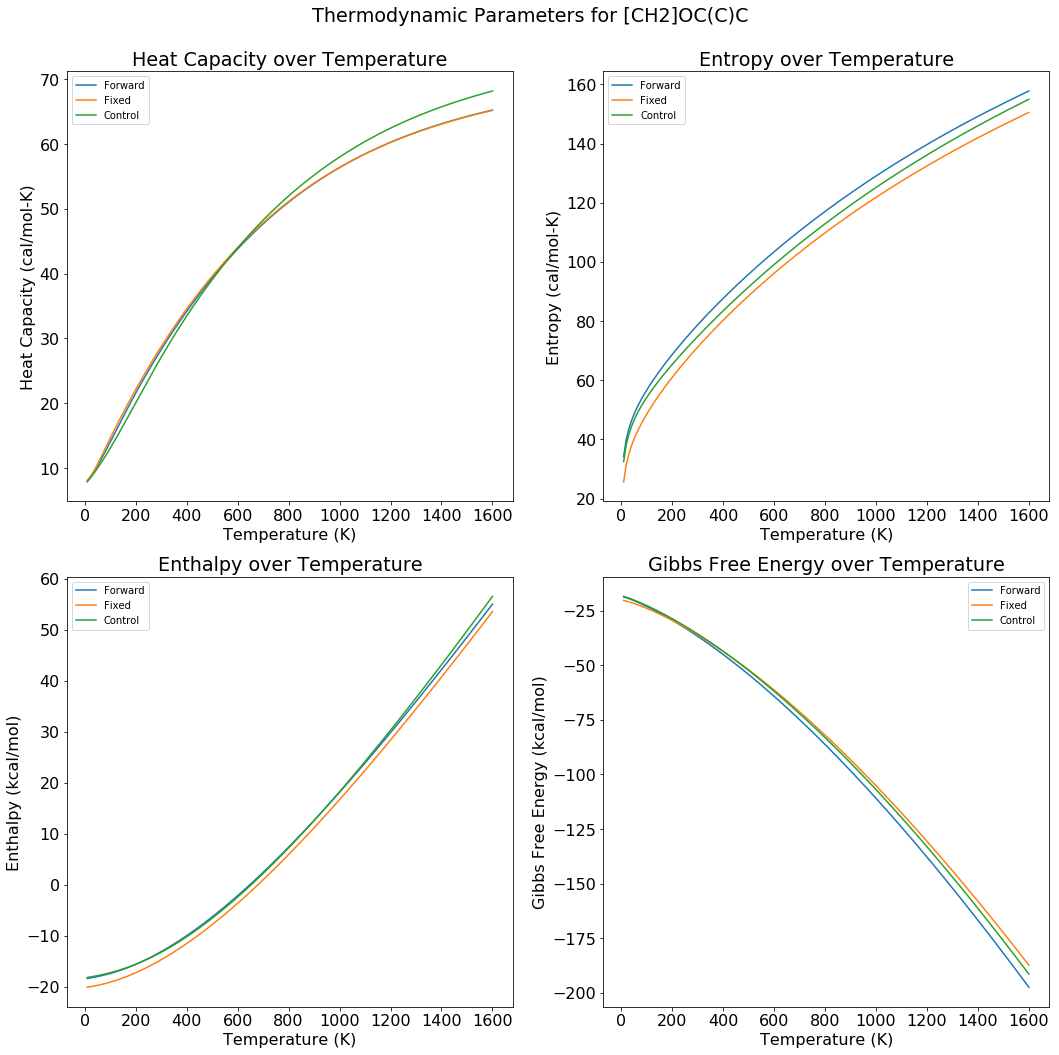

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/[CH2]C(C)OC/From_Workflow
Arkane execution initiated at Wed Apr 24 12:35:46 2019

################################################################
#                                                              #
# Automated Reaction Kinetics and Network Exploration (Arkane) #
#                                                              #
#   Version: 2.3.0                                             #
#   Authors: RMG Developers (rmg_dev@mit.edu)                  #
#   P.I.s:   William H. Green (whgreen@mit.edu)                #
#            Richard H. West (r.west@neu.edu)                  #
#   Website: http://reactionmechanismgenerator.github.io/      #
#                                                              #
################################################################

Loading species FBRHVBFW_for...
Assigned a frequency scale factor of 0.955 for model chemistry M06-2X/cc-pVTZ


Loading statistical mechanics paramet

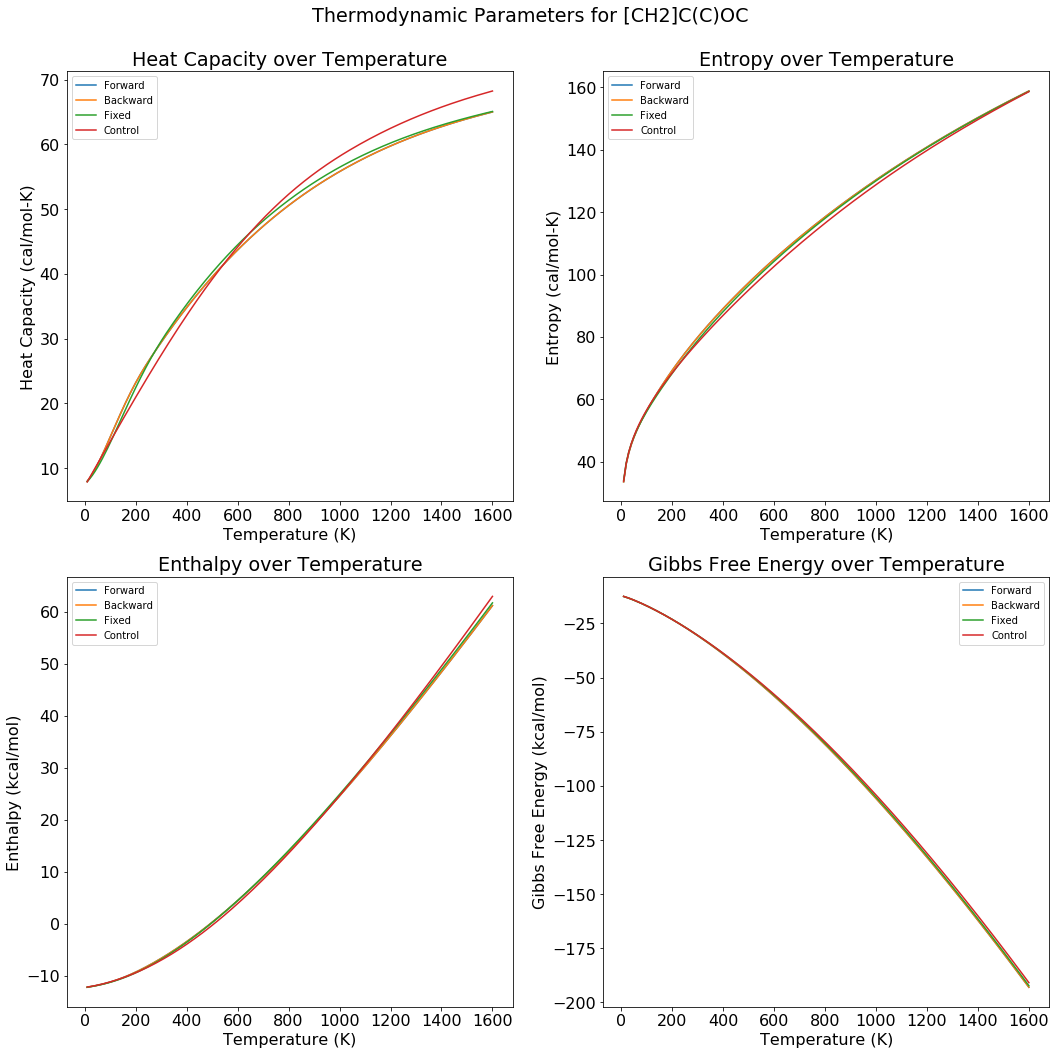

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/CCC(=O)OC/From_Workflow
Arkane execution initiated at Wed Apr 24 12:35:54 2019

################################################################
#                                                              #
# Automated Reaction Kinetics and Network Exploration (Arkane) #
#                                                              #
#   Version: 2.3.0                                             #
#   Authors: RMG Developers (rmg_dev@mit.edu)                  #
#   P.I.s:   William H. Green (whgreen@mit.edu)                #
#            Richard H. West (r.west@neu.edu)                  #
#   Website: http://reactionmechanismgenerator.github.io/      #
#                                                              #
################################################################

Loading species RJUFJBKO_for...
Assigned a frequency scale factor of 0.955 for model chemistry M06-2X/cc-pVTZ


Loading statistical mechanics parameter

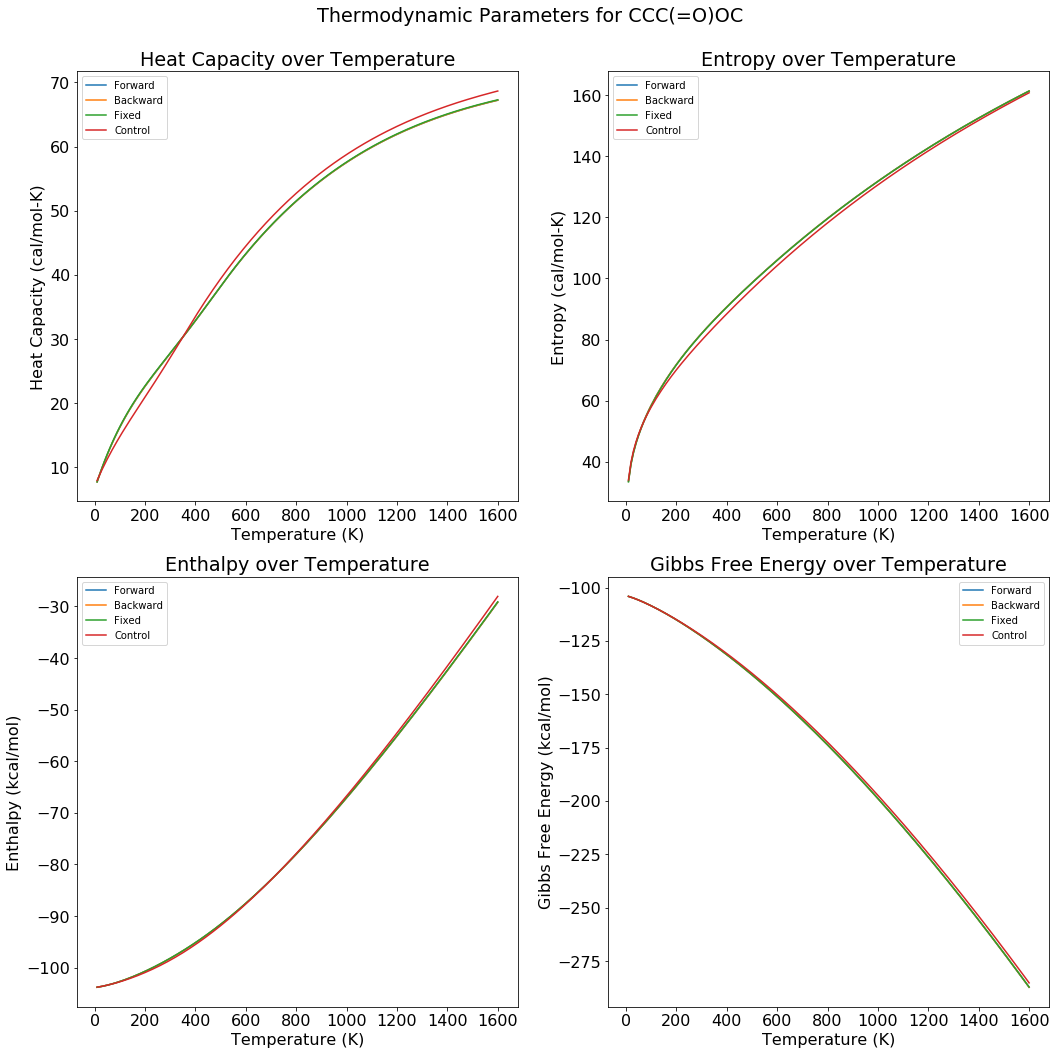

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/C[CH]C(=O)OC/From_Workflow
Arkane execution initiated at Wed Apr 24 12:36:02 2019

################################################################
#                                                              #
# Automated Reaction Kinetics and Network Exploration (Arkane) #
#                                                              #
#   Version: 2.3.0                                             #
#   Authors: RMG Developers (rmg_dev@mit.edu)                  #
#   P.I.s:   William H. Green (whgreen@mit.edu)                #
#            Richard H. West (r.west@neu.edu)                  #
#   Website: http://reactionmechanismgenerator.github.io/      #
#                                                              #
################################################################

Loading species DUEVIJNW_for...
Assigned a frequency scale factor of 0.955 for model chemistry M06-2X/cc-pVTZ


Loading statistical mechanics parame

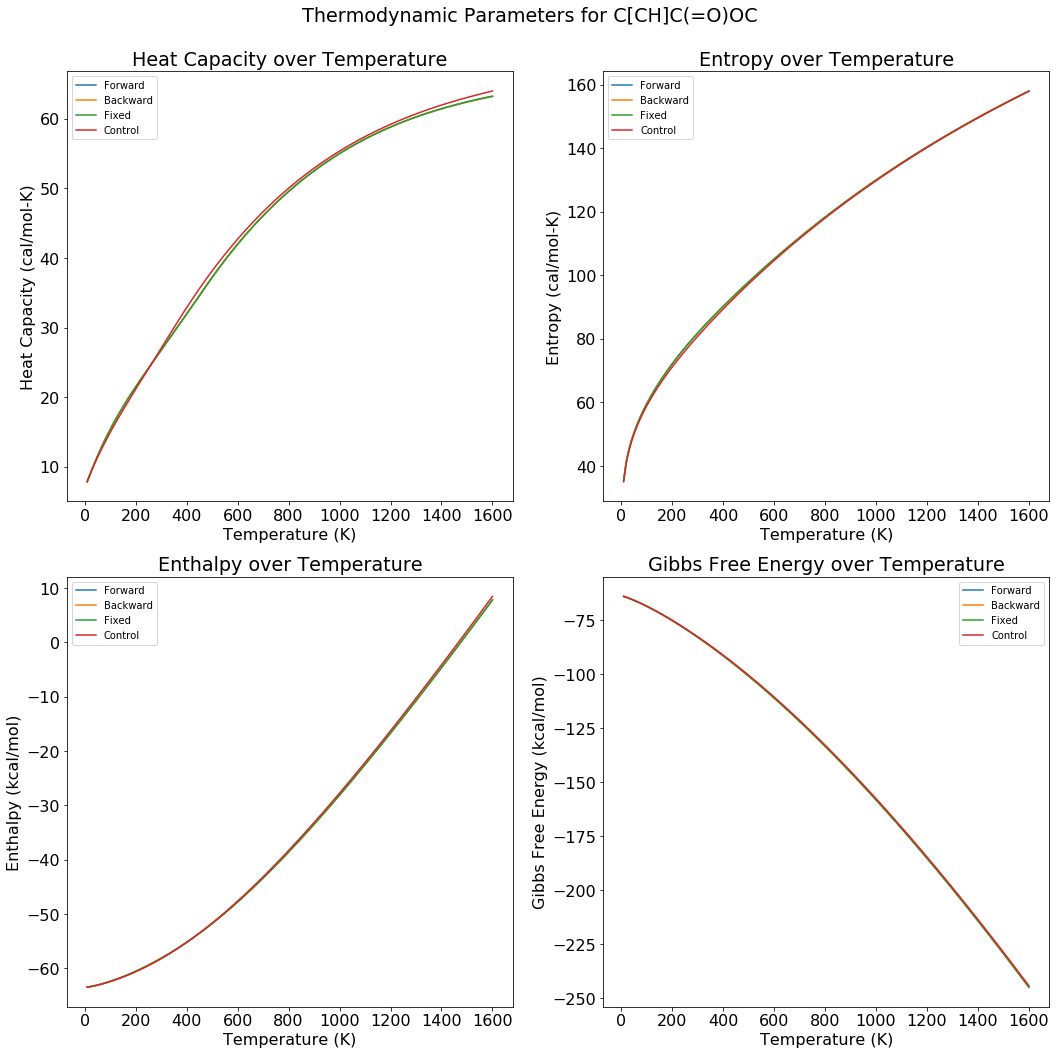

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/[CH2]CC(=O)OC/From_Workflow
Arkane execution initiated at Wed Apr 24 12:36:10 2019

################################################################
#                                                              #
# Automated Reaction Kinetics and Network Exploration (Arkane) #
#                                                              #
#   Version: 2.3.0                                             #
#   Authors: RMG Developers (rmg_dev@mit.edu)                  #
#   P.I.s:   William H. Green (whgreen@mit.edu)                #
#            Richard H. West (r.west@neu.edu)                  #
#   Website: http://reactionmechanismgenerator.github.io/      #
#                                                              #
################################################################

Loading species NPQBOSHS_for...
Assigned a frequency scale factor of 0.955 for model chemistry M06-2X/cc-pVTZ


Loading statistical mechanics param

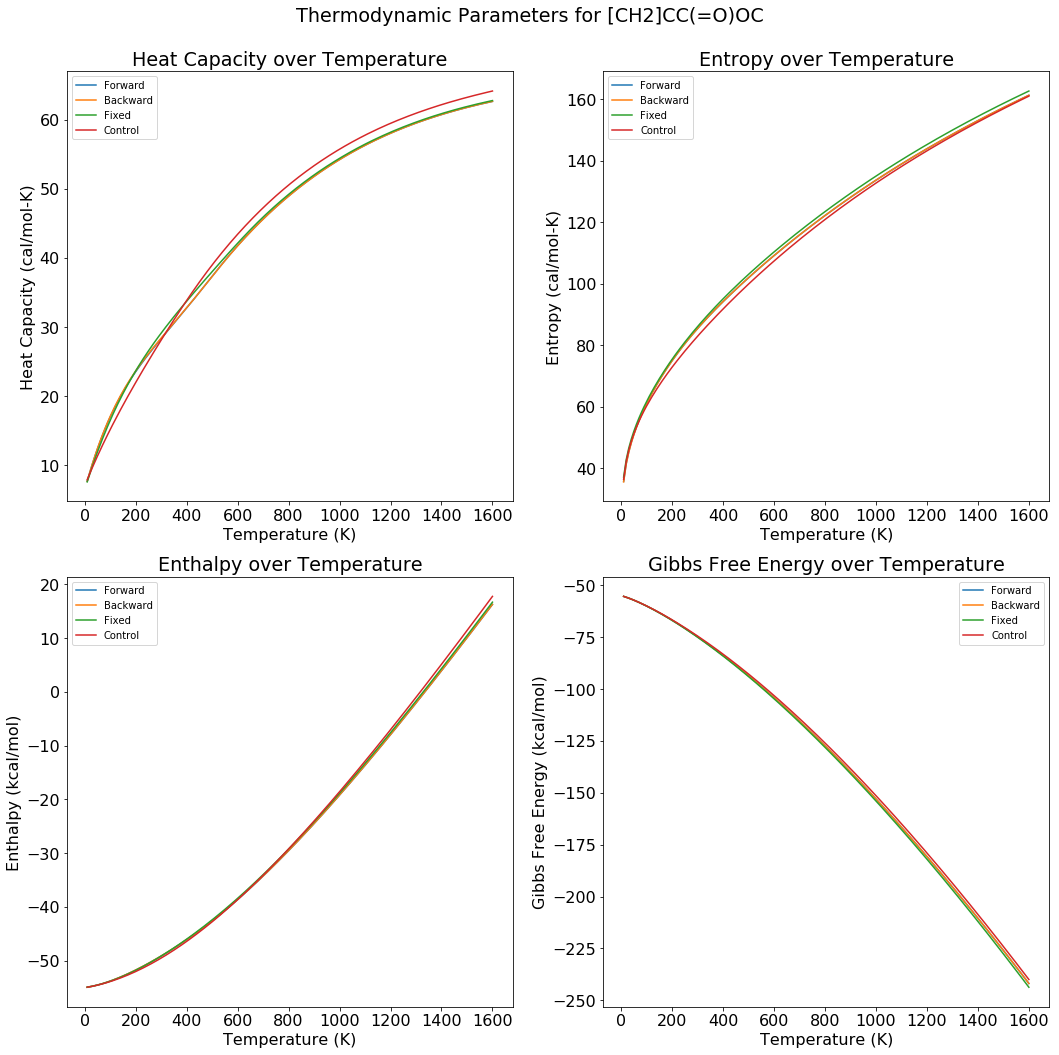

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/[CH2]OC(=O)CC/From_Workflow
Arkane execution initiated at Wed Apr 24 12:36:17 2019

################################################################
#                                                              #
# Automated Reaction Kinetics and Network Exploration (Arkane) #
#                                                              #
#   Version: 2.3.0                                             #
#   Authors: RMG Developers (rmg_dev@mit.edu)                  #
#   P.I.s:   William H. Green (whgreen@mit.edu)                #
#            Richard H. West (r.west@neu.edu)                  #
#   Website: http://reactionmechanismgenerator.github.io/      #
#                                                              #
################################################################

Loading species OJWHOIQF_for...
Assigned a frequency scale factor of 0.955 for model chemistry M06-2X/cc-pVTZ


Loading statistical mechanics param

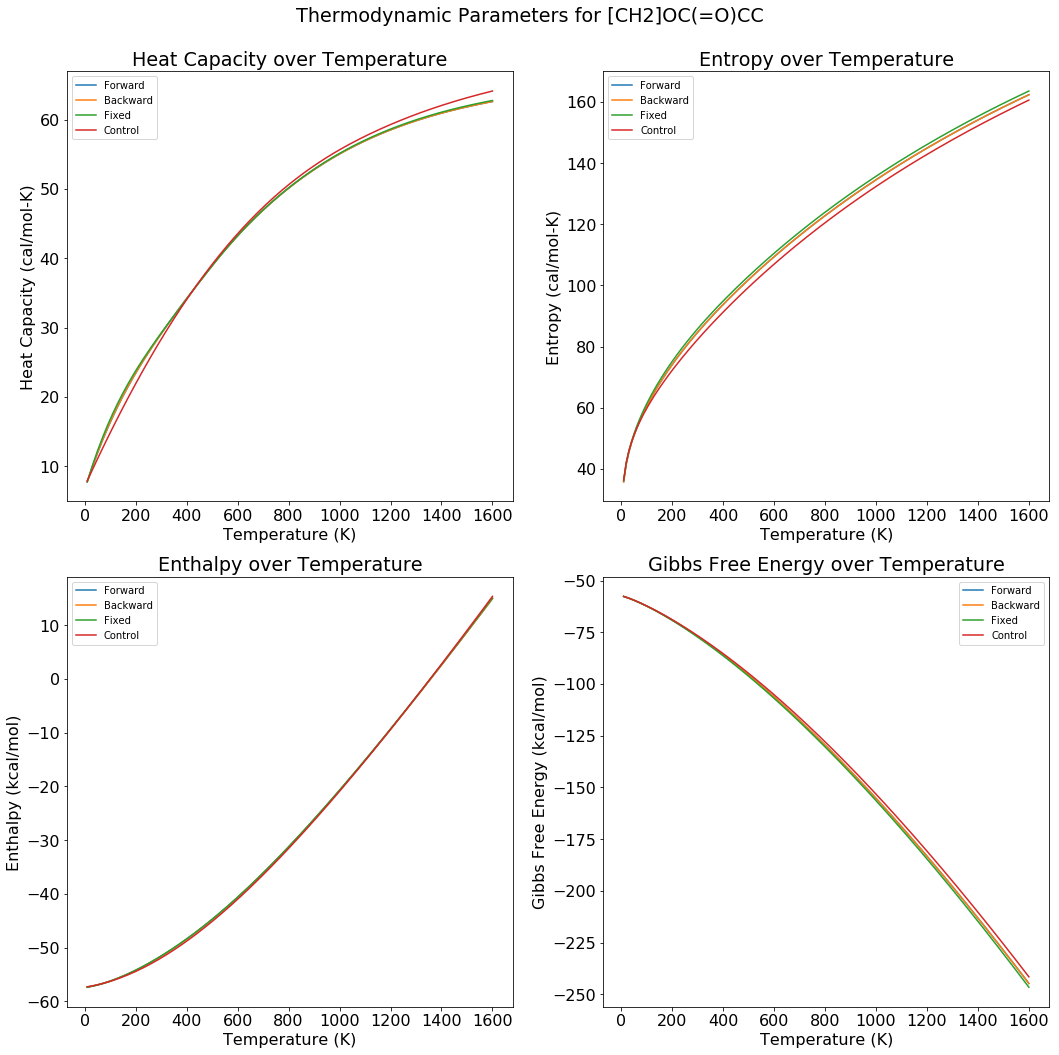

In [9]:
from autotst.species import Conformer
from rdkit import Chem
import os

SMILES_list = [
    'CCCCO',
    'CCCC[O]',
    'CCC[CH]O',
    'CC[CH]CO',
    'C[CH]CCO',
    '[CH2]CCCO',
    'CCOC',
    'C[CH]OC',
    'CCO[CH2]',
    '[CH2]COC',
    'COC(C)C',
    'CO[C](C)C',
    '[CH2]OC(C)C',
    '[CH2]C(C)OC',
    'CCC(=O)OC',
    'C[CH]C(=O)OC',
    '[CH2]CC(=O)OC',
    '[CH2]OC(=O)CC'
]




for SMILES in SMILES_list:
    conf = Conformer(SMILES)
    steps = 36
    step_size = 10.0
    base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2'
    modelChemistry = 'M06-2X/cc-pVTZ'


    SMILES = conf.smiles
    augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
        Chem.MolFromSmiles(SMILES)))


    path = os.path.join(base_path, '{}/From_Workflow'.format(SMILES))
    os.chdir(path)
    print path





    max_attempt = 20
    freq_log = augInChIKey + '_GeoFreq_a{}.log'.format(max_attempt)

    while not exists_and_complete(freq_log):
        max_attempt -= 1
        assert max_attempt > 0, "Having trouble finding GeoFreq File"
        freq_log = augInChIKey + '_GeoFreq_a{}.log'.format(max_attempt)
        #print freq_log

    #print max_attempt




    forward_info = "rotors = [\n"
    backward_info = "rotors = [\n"
    fixed_info = "rotors = [\n"
    for torsion in conf.torsions:
        i, j, k, l = torsion.atom_indices

        forward_log = augInChIKey + '_{0}by{1}_tor{2}{3}_a{4}.log'.format(steps, step_size, j, k, max_attempt)  
        if exists_and_complete(forward_log):
            for_log_exists = True
            forward_info += get_rotor_line(conf, torsion, forward_log) + '\n'

        backward_log = augInChIKey + '_{0}by-{1}_tor{2}{3}_a{4}.log'.format(steps, step_size, j, k, max_attempt)
        if exists_and_complete(backward_log):
            bac_log_exists = True
            backward_info += get_rotor_line(conf, torsion, backward_log) + '\n'

        fixed_log = augInChIKey + '_{0}by{1}_tor{2}{3}_a{4}_F.log'.format(steps, step_size, j, k, max_attempt)
        if exists_and_complete(fixed_log):
            fix_log_exists = True
            fixed_info += get_rotor_line(conf, torsion, fixed_log) + '\n'

    if for_log_exists: forward_info += "]\n"
    if bac_log_exists: backward_info += "]\n"
    if fix_log_exists: fixed_info += "]\n"




    """print forward_info
    print '\n\n\n'
    print backward_info
    print '\n\n\n'
    print fixed_info
    print '\n\n\n'"""



    if fix_log_exists:
        for_arkspec = augInChIKey + '_ArkSpecies_forward.py'
        write_arkane_species(conf, for_arkspec, modelChemistry, freq_log, path, rotor_info=forward_info)
    
    if bac_log_exists:
        bac_arkspec = augInChIKey + '_ArkSpecies_backward.py'
        write_arkane_species(conf, bac_arkspec, modelChemistry, freq_log, path, rotor_info=backward_info)

    if fix_log_exists:
        fix_arkspec = augInChIKey + '_ArkSpecies_fixed.py'
        write_arkane_species(conf, fix_arkspec, modelChemistry, freq_log, path, rotor_info=fixed_info)

    con_arkspec = augInChIKey + '_ArkSpecies_control.py'
    write_arkane_species(conf, con_arkspec, modelChemistry, freq_log, path, rotor_info=None)


    if for_log_exists:
        for_arkthermo = augInChIKey + '_ArkThermo_forward.py'
        spec_name = augInChIKey[:8] + '_for'
        write_ArkaneThermoInput(for_arkthermo, modelChemistry, spec_name, for_arkspec, path=path)
    if bac_log_exists:
        bac_arkthermo = augInChIKey + '_ArkThermo_backward.py'
        spec_name = augInChIKey[:8] + '_bac'
        write_ArkaneThermoInput(bac_arkthermo, modelChemistry, spec_name, bac_arkspec, path=path)

    if fix_log_exists:
        fix_arkthermo = augInChIKey + '_ArkThermo_fixed.py'
        spec_name = augInChIKey[:8] + '_fix'
        write_ArkaneThermoInput(fix_arkthermo, modelChemistry, spec_name, fix_arkspec, path=path)
    
    con_arkthermo = augInChIKey + '_ArkThermo_control.py'
    spec_name = augInChIKey[:8] + '_con'
    write_ArkaneThermoInput(con_arkthermo, modelChemistry, spec_name, con_arkspec, path=path)


    #####

    if for_log_exists:
        for_ark = arkane.Arkane(inputFile=for_arkthermo, outputDirectory=path)
        for_ark.plot = False
        for_works = True
        try:
            for_ark.execute()
        except:
            for_works = False

    if bac_log_exists:
        bac_ark = arkane.Arkane(inputFile=bac_arkthermo, outputDirectory=path)
        bac_ark.plot = False
        bac_works = True
        try:
            bac_ark.execute()
        except:
            bac_works = False

    if fix_log_exists:
        fix_ark = arkane.Arkane(inputFile=fix_arkthermo, outputDirectory=path)
        fix_ark.plot = False
        fix_works = True
        try:
            fix_ark.execute()
        except:
            fix_works = False
    
    con_ark = arkane.Arkane(inputFile=con_arkthermo, outputDirectory=path)
    con_ark.plot = False
    con_works = True
    try:
        con_ark.execute()
    except:
        con_works = False


    ###

    temps = range(10,1610, 10)

    #Forward
    if for_works:
        for_job = for_ark.jobList[1]
        for_nasa = for_job.species.thermo

        for_cap = [for_nasa.getHeatCapacity(temp)/4.184 for temp in temps] # cal/mol-K
        for_entropy = [for_nasa.getEntropy(temp)/4.184 for temp in temps] # cal/mol-K
        for_enthalpy = [for_nasa.getEnthalpy(temp)/4184 for temp in temps] # kcal/mol
        for_gibbs = [for_nasa.getFreeEnergy(temp)/4184 for temp in temps] # kcal/mol

    #Backward
    if bac_works:
        bac_job = bac_ark.jobList[1]
        bac_nasa = bac_job.species.thermo

        bac_cap = [bac_nasa.getHeatCapacity(temp)/4.184 for temp in temps]
        bac_entropy = [bac_nasa.getEntropy(temp)/4.184 for temp in temps]
        bac_enthalpy = [bac_nasa.getEnthalpy(temp)/4184 for temp in temps]
        bac_gibbs = [bac_nasa.getFreeEnergy(temp)/4184 for temp in temps]

    #Fixed
    if fix_works:
        fix_job = fix_ark.jobList[1]
        fix_nasa = fix_job.species.thermo

        fix_cap = [fix_nasa.getHeatCapacity(temp)/4.184 for temp in temps]
        fix_entropy = [fix_nasa.getEntropy(temp)/4.184 for temp in temps]
        fix_enthalpy = [fix_nasa.getEnthalpy(temp)/4184 for temp in temps]
        fix_gibbs = [fix_nasa.getFreeEnergy(temp)/4184 for temp in temps]

    #Control
    if con_works:
        con_job = con_ark.jobList[1]
        con_nasa = con_job.species.thermo
        con_nasa.getHeatCapacity(100)

        con_cap = [con_nasa.getHeatCapacity(temp)/4.184 for temp in temps]
        con_entropy = [con_nasa.getEntropy(temp)/4.184 for temp in temps]
        con_enthalpy = [con_nasa.getEnthalpy(temp)/4184 for temp in temps]
        con_gibbs = [con_nasa.getFreeEnergy(temp)/4184 for temp in temps]

    import matplotlib
    fig = plt.figure(figsize=(15,15))

    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 16}
    matplotlib.rc('font', **font)

    fig.suptitle('Thermodynamic Parameters for {}'.format(SMILES))
    plt.subplot(2, 2, 1)
    plt.title('Heat Capacity over Temperature')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Heat Capacity (cal/mol-K)')
    if for_works: plt.plot(temps, for_cap, label='Forward')
    if bac_works: plt.plot(temps, bac_cap, label='Backward')
    if fix_works: plt.plot(temps, fix_cap, label='Fixed')
    if con_works: plt.plot(temps, con_cap, label='Control')
    plt.legend(prop={'size': 10})

    plt.subplot(2, 2, 2)
    plt.title('Entropy over Temperature')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Entropy (cal/mol-K)')
    if for_works: plt.plot(temps, for_entropy, label='Forward')
    if bac_works: plt.plot(temps, bac_entropy, label='Backward')
    if fix_works: plt.plot(temps, fix_entropy, label='Fixed')
    if con_works: plt.plot(temps, con_entropy, label='Control')
    plt.legend(prop={'size': 10})

    plt.subplot(2, 2, 3)
    plt.title('Enthalpy over Temperature')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Enthalpy (kcal/mol)')
    if for_works: plt.plot(temps, for_enthalpy, label='Forward')
    if bac_works: plt.plot(temps, bac_enthalpy, label='Backward')
    if fix_works: plt.plot(temps, fix_enthalpy, label='Fixed')
    if con_works: plt.plot(temps, con_enthalpy, label='Control')
    plt.legend(prop={'size': 10})

    plt.subplot(2, 2, 4)
    plt.title('Gibbs Free Energy over Temperature')
    plt.xlabel('Temperature (K)')
    plt.ylabel("Gibbs Free Energy (kcal/mol)")
    if for_works: plt.plot(temps, for_gibbs, label='Forward')
    if bac_works: plt.plot(temps, bac_gibbs, label='Backward')
    if fix_works: plt.plot(temps, fix_gibbs, label='Fixed')
    if con_works: plt.plot(temps, con_gibbs, label='Control')
    plt.legend(prop={'size': 10})
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

    arkane_plots = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/arkane_plots'
    filename = os.path.join(arkane_plots, '{}_a{}.png'.format(SMILES, max_attempt))
    fig.savefig(filename, format='png')


/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/OOCC(C)O[O]/From_Workflow
Arkane execution initiated at Wed Apr 24 12:41:04 2019

################################################################
#                                                              #
# Automated Reaction Kinetics and Network Exploration (Arkane) #
#                                                              #
#   Version: 2.3.0                                             #
#   Authors: RMG Developers (rmg_dev@mit.edu)                  #
#   P.I.s:   William H. Green (whgreen@mit.edu)                #
#            Richard H. West (r.west@neu.edu)                  #
#   Website: http://reactionmechanismgenerator.github.io/      #
#                                                              #
################################################################

Loading species XDJVAJLI_for...
Assigned a frequency scale factor of 0.955 for model chemistry M06-2X/cc-pVTZ


Loading statistical mechanics paramet

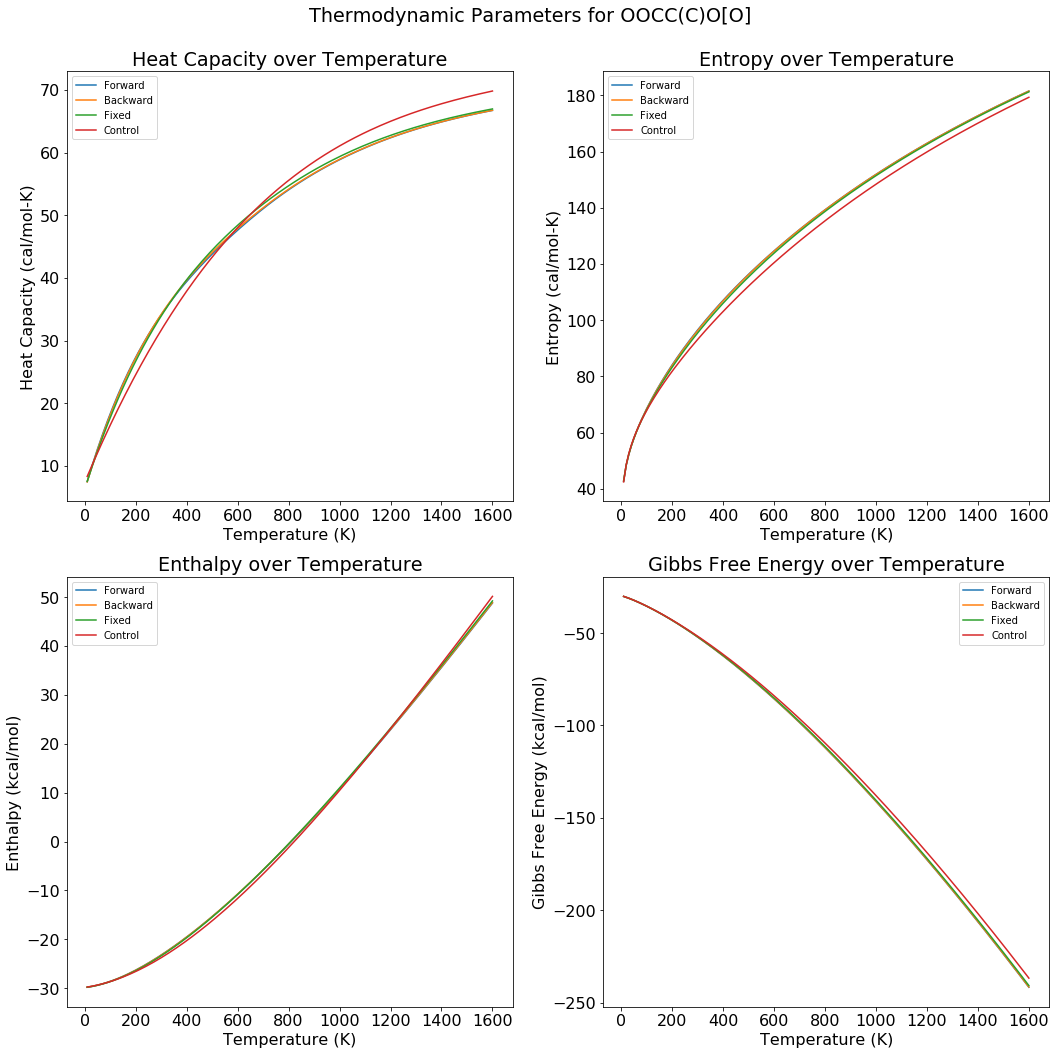

In [12]:
from autotst.species import Conformer
from rdkit import Chem
import os

SMILES_list = [
    'OOCC(C)O[O]'
]




for SMILES in SMILES_list:
    conf = Conformer(SMILES)
    steps = 36
    step_size = 10.0
    base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2'
    modelChemistry = 'M06-2X/cc-pVTZ'


    SMILES = conf.smiles
    augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
        Chem.MolFromSmiles(SMILES)))


    path = os.path.join(base_path, '{}/From_Workflow'.format(SMILES))
    os.chdir(path)
    print path





    max_attempt = 20
    freq_log = augInChIKey + '_GeoFreq_a{}.log'.format(max_attempt)

    while not exists_and_complete(freq_log):
        max_attempt -= 1
        assert max_attempt > 0, "Having trouble finding GeoFreq File"
        freq_log = augInChIKey + '_GeoFreq_a{}.log'.format(max_attempt)
        #print freq_log

    #print max_attempt




    forward_info = "rotors = [\n"
    backward_info = "rotors = [\n"
    fixed_info = "rotors = [\n"
    for torsion in conf.torsions:
        i, j, k, l = torsion.atom_indices

        forward_log = augInChIKey + '_{0}by{1}_tor{2}{3}_a{4}.log'.format(steps, step_size, j, k, max_attempt)  
        if exists_and_complete(forward_log):
            for_log_exists = True
            forward_info += get_rotor_line(conf, torsion, forward_log) + '\n'

        backward_log = augInChIKey + '_{0}by-{1}_tor{2}{3}_a{4}.log'.format(steps, step_size, j, k, max_attempt)
        if exists_and_complete(backward_log):
            bac_log_exists = True
            backward_info += get_rotor_line(conf, torsion, backward_log) + '\n'

        fixed_log = augInChIKey + '_{0}by{1}_tor{2}{3}_a{4}_F.log'.format(steps, step_size, j, k, max_attempt)
        if exists_and_complete(fixed_log):
            fix_log_exists = True
            fixed_info += get_rotor_line(conf, torsion, fixed_log) + '\n'

    if for_log_exists: forward_info += "]\n"
    if bac_log_exists: backward_info += "]\n"
    if fix_log_exists: fixed_info += "]\n"




    """print forward_info
    print '\n\n\n'
    print backward_info
    print '\n\n\n'
    print fixed_info
    print '\n\n\n'"""



    if fix_log_exists:
        for_arkspec = augInChIKey + '_ArkSpecies_forward.py'
        write_arkane_species(conf, for_arkspec, modelChemistry, freq_log, path, rotor_info=forward_info)
    
    if bac_log_exists:
        bac_arkspec = augInChIKey + '_ArkSpecies_backward.py'
        write_arkane_species(conf, bac_arkspec, modelChemistry, freq_log, path, rotor_info=backward_info)

    if fix_log_exists:
        fix_arkspec = augInChIKey + '_ArkSpecies_fixed.py'
        write_arkane_species(conf, fix_arkspec, modelChemistry, freq_log, path, rotor_info=fixed_info)

    con_arkspec = augInChIKey + '_ArkSpecies_control.py'
    write_arkane_species(conf, con_arkspec, modelChemistry, freq_log, path, rotor_info=None)


    if for_log_exists:
        for_arkthermo = augInChIKey + '_ArkThermo_forward.py'
        spec_name = augInChIKey[:8] + '_for'
        write_ArkaneThermoInput(for_arkthermo, modelChemistry, spec_name, for_arkspec, path=path)
    if bac_log_exists:
        bac_arkthermo = augInChIKey + '_ArkThermo_backward.py'
        spec_name = augInChIKey[:8] + '_bac'
        write_ArkaneThermoInput(bac_arkthermo, modelChemistry, spec_name, bac_arkspec, path=path)

    if fix_log_exists:
        fix_arkthermo = augInChIKey + '_ArkThermo_fixed.py'
        spec_name = augInChIKey[:8] + '_fix'
        write_ArkaneThermoInput(fix_arkthermo, modelChemistry, spec_name, fix_arkspec, path=path)
    
    con_arkthermo = augInChIKey + '_ArkThermo_control.py'
    spec_name = augInChIKey[:8] + '_con'
    write_ArkaneThermoInput(con_arkthermo, modelChemistry, spec_name, con_arkspec, path=path)


    #####

    if for_log_exists:
        for_ark = arkane.Arkane(inputFile=for_arkthermo, outputDirectory=path)
        for_ark.plot = False
        for_works = True
        try:
            for_ark.execute()
        except:
            for_works = False

    if bac_log_exists:
        bac_ark = arkane.Arkane(inputFile=bac_arkthermo, outputDirectory=path)
        bac_ark.plot = False
        bac_works = True
        try:
            bac_ark.execute()
        except:
            bac_works = False

    if fix_log_exists:
        fix_ark = arkane.Arkane(inputFile=fix_arkthermo, outputDirectory=path)
        fix_ark.plot = False
        fix_works = True
        try:
            fix_ark.execute()
        except:
            fix_works = False
    
    con_ark = arkane.Arkane(inputFile=con_arkthermo, outputDirectory=path)
    con_ark.plot = False
    con_works = True
    try:
        con_ark.execute()
    except:
        con_works = False


    ###

    temps = range(10,1610, 10)

    #Forward
    if for_works:
        for_job = for_ark.jobList[1]
        for_nasa = for_job.species.thermo

        for_cap = [for_nasa.getHeatCapacity(temp)/4.184 for temp in temps] # cal/mol-K
        for_entropy = [for_nasa.getEntropy(temp)/4.184 for temp in temps] # cal/mol-K
        for_enthalpy = [for_nasa.getEnthalpy(temp)/4184 for temp in temps] # kcal/mol
        for_gibbs = [for_nasa.getFreeEnergy(temp)/4184 for temp in temps] # kcal/mol

    #Backward
    if bac_works:
        bac_job = bac_ark.jobList[1]
        bac_nasa = bac_job.species.thermo

        bac_cap = [bac_nasa.getHeatCapacity(temp)/4.184 for temp in temps]
        bac_entropy = [bac_nasa.getEntropy(temp)/4.184 for temp in temps]
        bac_enthalpy = [bac_nasa.getEnthalpy(temp)/4184 for temp in temps]
        bac_gibbs = [bac_nasa.getFreeEnergy(temp)/4184 for temp in temps]

    #Fixed
    if fix_works:
        fix_job = fix_ark.jobList[1]
        fix_nasa = fix_job.species.thermo

        fix_cap = [fix_nasa.getHeatCapacity(temp)/4.184 for temp in temps]
        fix_entropy = [fix_nasa.getEntropy(temp)/4.184 for temp in temps]
        fix_enthalpy = [fix_nasa.getEnthalpy(temp)/4184 for temp in temps]
        fix_gibbs = [fix_nasa.getFreeEnergy(temp)/4184 for temp in temps]

    #Control
    if con_works:
        con_job = con_ark.jobList[1]
        con_nasa = con_job.species.thermo
        con_nasa.getHeatCapacity(100)

        con_cap = [con_nasa.getHeatCapacity(temp)/4.184 for temp in temps]
        con_entropy = [con_nasa.getEntropy(temp)/4.184 for temp in temps]
        con_enthalpy = [con_nasa.getEnthalpy(temp)/4184 for temp in temps]
        con_gibbs = [con_nasa.getFreeEnergy(temp)/4184 for temp in temps]

    import matplotlib
    fig = plt.figure(figsize=(15,15))

    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 16}
    matplotlib.rc('font', **font)

    fig.suptitle('Thermodynamic Parameters for {}'.format(SMILES))
    plt.subplot(2, 2, 1)
    plt.title('Heat Capacity over Temperature')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Heat Capacity (cal/mol-K)')
    if for_works: plt.plot(temps, for_cap, label='Forward')
    if bac_works: plt.plot(temps, bac_cap, label='Backward')
    if fix_works: plt.plot(temps, fix_cap, label='Fixed')
    if con_works: plt.plot(temps, con_cap, label='Control')
    plt.legend(prop={'size': 10})

    plt.subplot(2, 2, 2)
    plt.title('Entropy over Temperature')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Entropy (cal/mol-K)')
    if for_works: plt.plot(temps, for_entropy, label='Forward')
    if bac_works: plt.plot(temps, bac_entropy, label='Backward')
    if fix_works: plt.plot(temps, fix_entropy, label='Fixed')
    if con_works: plt.plot(temps, con_entropy, label='Control')
    plt.legend(prop={'size': 10})

    plt.subplot(2, 2, 3)
    plt.title('Enthalpy over Temperature')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Enthalpy (kcal/mol)')
    if for_works: plt.plot(temps, for_enthalpy, label='Forward')
    if bac_works: plt.plot(temps, bac_enthalpy, label='Backward')
    if fix_works: plt.plot(temps, fix_enthalpy, label='Fixed')
    if con_works: plt.plot(temps, con_enthalpy, label='Control')
    plt.legend(prop={'size': 10})

    plt.subplot(2, 2, 4)
    plt.title('Gibbs Free Energy over Temperature')
    plt.xlabel('Temperature (K)')
    plt.ylabel("Gibbs Free Energy (kcal/mol)")
    if for_works: plt.plot(temps, for_gibbs, label='Forward')
    if bac_works: plt.plot(temps, bac_gibbs, label='Backward')
    if fix_works: plt.plot(temps, fix_gibbs, label='Fixed')
    if con_works: plt.plot(temps, con_gibbs, label='Control')
    plt.legend(prop={'size': 10})
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

    arkane_plots = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/arkane_plots'
    filename = os.path.join(arkane_plots, '{}_a{}.png'.format(SMILES, max_attempt))
    fig.savefig(filename, format='png')


In [14]:
"""print 'Entropy:      ', for_nasa.getEntropy(298)/4.184
print 'Enthalpy:     ', for_nasa.getEnthalpy(298)/4184
print 'Heat Capcity: ', for_nasa.getHeatCapacity(298)/4.184
print 'Gibbs:        ', for_nasa.getFreeEnergy(298)/4184

columns = ['Method', 'Entropy (cal/mol-K)', 'Enthalpy (kcal/mol)', 'Cp (cal/mol-K)']
rows = ['Control', 'Forward', 'Backward', 'Fixed']
data = [[con_nasa.getEntropy(298)/4.184, con_nasa.getEnthalpy(298)/4184, con_nasa.getHeatCapacity(298)/4.184],
        [for_nasa.getEntropy(298)/4.184, for_nasa.getEnthalpy(298)/4184, for_nasa.getHeatCapacity(298)/4.184],
        [bac_nasa.getEntropy(298)/4.184, bac_nasa.getEnthalpy(298)/4184, bac_nasa.getHeatCapacity(298)/4.184],
        [fix_nasa.getEntropy(298)/4.184, fix_nasa.getEnthalpy(298)/4184, fix_nasa.getHeatCapacity(298)/4.184],
       ]

cellText = []
for row in data:
    rowText = ['{:0.2f}'.format(datum) for datum in row]
    cellText.append(rowText)
    

fig.patch.set_visible(False)
plt.axis('off')
plt.axis('tight')

plt.table(cellText=cellText,
         rowLabels=rows,
         colLabels=columns,
         loc='top')

cellText
"""
x=1

In [14]:
from autotst.species import Conformer
from autotst.calculators.gaussian import read_gaussian_out
import cclib

def update_Conformer(conformer, file_name, path=None):
    """
    Updates conformer geometry from Gaussian geometry optimization output. If no filename specified tries by naming convention within path

    ACHTUNG!!! No Checks for whether conformer in file matches given conformer

    filename :: Geometry optimization log from Gaussian
    path :: path of file, default to cwd
    """

    
    if path is None:
        path = os.getcwd()
    
    os.chdir(path)
    print os.getcwd()
    #print len(conformer.ase_molecule)
    #print len(read_gaussian_out(file_name))
    
    conformer.ase_molecule = read_gaussian_out(file_name)
    
    conformer.update_coords()
    
    return conformer


SMILES = 'OOCC(C)O[O]'
conf = Conformer(SMILES)
conf.view()
print os.getcwd()
path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run3/OOCC(C)O[O]/From_Workflow'
os.chdir(path)
log = 'XDJVAJLIXKTENM-UHFFFAOYSA-N_GeoFreq_c1_a1.log'
parser = cclib.io.ccread(log)
energy =[parser.scfenergies[i] for status,i in enumerate(parser.optstatus) if status==2][-1]
print '\nSCF Energy: {}'.format(energy)
log_conf = update_Conformer(conf, log, path=path)
log_conf.view()




path2 = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/OOCC(C)O[O]/From_Workflow2'
os.chdir(path2)
log2 = 'XDJVAJLIXKTENM-UHFFFAOYSA-N_GeoFreq_a0.log'
parser2 = cclib.io.ccread(log2)
energy2 =[parser2.scfenergies[i] for status,i in enumerate(parser2.optstatus) if status==2][-1]
print '\nSCF Energy: {}'.format(energy2)
log_conf2 = update_Conformer(conf, log2, path=path2)
log_conf2.view()

path3 = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run3/OOCC(C)O[O]'
os.chdir(path3)
log3 = 'ring.log'
parser3 = cclib.io.ccread(log3)
energy3 =[parser3.scfenergies[i] for status,i in enumerate(parser3.optstatus) if status==2][-1]
print '\nSCF Energy: {}'.format(energy3)
log_conf3 = update_Conformer(conf, log3, path=path3)
log_conf3.view()

path4 = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run3/OOCC(C)O[O]'
os.chdir(path4)
log4 = 'ring2.log'
parser4 = cclib.io.ccread(log4)
energy4 =[parser4.scfenergies[i] for status,i in enumerate(parser4.optstatus) if status==2][-1]
print '\nSCF Energy: {}'.format(energy4)
log_conf4 = update_Conformer(conf, log4, path=path4)
log_conf4.view()


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run3/OOCC(C)O[O]
[Gaussian XDJVAJLIXKTENM-UHFFFAOYSA-N_GeoFreq_c1_a1.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian XDJVAJLIXKTENM-UHFFFAOYSA-N_GeoFreq_c1_a1.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian XDJVAJLIXKTENM-UHFFFAOYSA-N_GeoFreq_c1_a1.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian XDJVAJLIXKTENM-UHFFFAOYSA-N_GeoFreq_c1_a1.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian XDJVAJLIXKTENM-UHFFFAOYSA-N_GeoFreq_c1_a1.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian XDJVAJLIXKTENM-UHFFFAOYSA-N_GeoFreq_c1_a1.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian XDJVAJLIXKTENM-UHFFFAOYSA-N_GeoFreq_c1_a1.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian XDJVAJLIXKTENM-

You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

[Gaussian XDJVAJLIXKTENM-UHFFFAOYSA-N_GeoFreq_a0.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian XDJVAJLIXKTENM-UHFFFAOYSA-N_GeoFreq_a0.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian XDJVAJLIXKTENM-UHFFFAOYSA-N_GeoFreq_a0.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian XDJVAJLIXKTENM-UHFFFAOYSA-N_GeoFreq_a0.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian XDJVAJLIXKTENM-UHFFFAOYSA-N_GeoFreq_a0.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian XDJVAJLIXKTENM-UHFFFAOYSA-N_GeoFreq_a0.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian XDJVAJLIXKTENM-UHFFFAOYSA-N_GeoFreq_a0.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian XDJVAJLIXKTENM-UHFFFAOYSA-N_GeoFreq_a0.log Warning: ] Number of basis functions (nbasis) has changed 

You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

[Gaussian ring.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian ring.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian ring.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian ring.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian ring.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian ring.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian ring.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian ring.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian ring.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian ring.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian ring.log Warning: ] Number of basis functions (nbasis) has c

You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

[Gaussian ring2.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian ring2.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian ring2.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian ring2.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian ring2.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian ring2.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian ring2.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian ring2.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian ring2.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian ring2.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian ring2.log Warning: ] Number of basis functions (nb

[Gaussian ring2.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian ring2.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian ring2.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian ring2.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian ring2.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian ring2.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian ring2.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian ring2.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian ring2.log Warning: ] Number of basis functions (nbasis) has changed from 301 to 336
[Gaussian ring2.log Warning: ] Number of basis functions (nbasis) has changed from 336 to 301
[Gaussian ring2.log Warning: ] Number of basis functions (nb

You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [30]:
energy =[parser.scfenergies[i] for status,i in enumerate(parser.optstatus) if status==2][-1]
energy

-11405.883142027795

In [1]:
"""if ThermoJob:
    log += ['Beginning Thermo Calculations']
    thermo_filename = augInChIKey.strip('-N') + '_Thermo.py'

    out_path = path
    species_name = augInChIKey.strip('-N')

    if not os.path.isfile(thermo_filename):
        log += ['Thermo input file NOT FOUND\n\t{0} NOT FOUND for {1}\t\nGenerating one now...'.format(thermo_filename, SMILES)]

        write_ArkaneThermoInput(thermo_filename, modelChemistry, species_name, species_file)

    log += ['Executing Arkane Thermo Job for {0}\n\tAKA {1}'.format(species_file, SMILES)]
    log += ['Arkane log named "arkane.log"\n\tat {0}'.format(path)]

    ark = arkane.Arkane(inputFile=thermo_filename, outputDirectory=out_path)
    ark.plot = False
    ark.execute()
    ark_dict[SMILES] = ark"""
x=1